In [33]:
import cv2
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense

# Method to build confusion matrix for various classifiers
def create_confusion(expected, predicted, axis_labels):
    
    # argmax() used to remove one-hot encoding
    cm = confusion_matrix(expected.argmax(axis=1), predicted.argmax(axis=1))
    cm = pd.DataFrame(cm, index = [i for i in axis_labels], columns = [i for i in axis_labels])
    plt.figure(figsize=(30, 21))
    sns.heatmap(cm, annot=True)

# Method to develop roc curves for each label and print
def roc_auc(expected, predicted, number_of_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
              'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    
    for i in range(number_of_classes):
        fpr[i], tpr[i], _ = roc_curve(expected[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    for i in range(number_of_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC Curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.xlim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        if(i < 10):
            plt.title('Reciever Operating Characteristic for Label %0.0f' % i)
        else:
            string = 'Reciever Operating Characteristic for Label ' + letters[i-10]
            plt.title(string)
        plt.legend(loc='lower right')
        plt.show
        
    macro_roc_auc_ovo = roc_auc_score(expected, predicted, multi_class='ovo', average='macro')
    weighted_roc_auc_ovo = roc_auc_score(expected, predicted, multi_class='ovo', average='weighted')

    macro_roc_auc_ovr = roc_auc_score(expected, predicted, multi_class='ovr', average='macro')
    weighted_roc_auc_ovr = roc_auc_score(expected, predicted, multi_class='ovr', average='weighted')

    print("One-vs-One ROC AUC scores:\n{:.6f} (macro), \n{:.6f} (weighted)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("\nOne-vs-Rest ROC AUC scores:\n{:.6f} (macro), \n{:.6f} (weighted)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
def process_image(image):
    image = cv2.imread(image)
    image = cv2.resize(image, (700, 500))
    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(grey.copy(), 100, 255, cv2.THRESH_BINARY_INV)
    _, contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    _, y1, _, _ = cv2.boundingRect(contours[0])

    preprocessed_digits = []
    x_coord = []
    y_coord = []
    y_row = []
    df = pd.DataFrame()

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
    
        # Cropping digit out of image
        digit = thresh[y:y+h, x:x+w]

        # Check size of digit to attempt to keep extraneous markings out of data
        if(digit.size > 325):

            if(y_row == []):
                y_row.append(y)

            # Create rectangle around each digit in image to display
            cv2.rectangle(image, (x, y), (x+w, y+h), color=(255, 0, 0))

            # Resizing digit to 18x18 to be centered in 28x28 in image
            resized_digit = cv2.resize(digit, (18,18))

            # Pad digit with 5 pixels of black on each side to have digit centered in 28x28 image
            padded_digit = np.pad(resized_digit, ((5,5),(5,5)), 'constant', constant_values=0)
            
            # Assigns each item a y_coordinate based on line it is on
            # Handles images with multiple lines of text
            y_flag = False
            for row_y in y_row:
                # Checks if item is within buffer range of any row
                if((y < (row_y + h/1)) and (y > row_y - h/1)):
                    y = row_y
                    y_flag = True
                if(y_flag == True):
                    break
            # If item is not within range of another row it starts its own row
            if(y_flag == False):
                y_row.append(y)


            # Appending final preprocessed digit to list
            preprocessed_digits.append(padded_digit)
            x_coord.append(x)
            y_coord.append(y)
    
    # Build dataframe containing all image info, their x-coordinates and row's y-coordinate
    df['Preprocessed_Digits'] = preprocessed_digits
    df['X_Coord'] = x_coord
    df['Y_Coord'] = y_coord
    
    # Sorting in order to process text line-by-line
    df = df.sort_values(by=['Y_Coord', 'X_Coord'], ascending=True)
    df = df.reset_index(drop=True)
    
    shaped_digits = []
    
    # Processed_digit features appended into list
    for digit in df['Preprocessed_Digits']:
        shaped_digits.append(digit)
    
    # Reshape 28x28 digit features into 1x784 array then normalize features
    shaped_digits = np.array(shaped_digits)
    shaped_digits = shaped_digits.reshape(shaped_digits.shape[0], 784).astype('float32')
    shaped_digits /= 255
    
    # Plot image with boxed digits
    plt.imshow(image, cmap='gray')
    plt.show
    
    # Return digit array and dataframe with coordinates
    return shaped_digits, df

# Digit Data

Using TensorFlow backend.


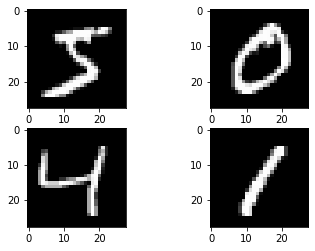

In [3]:
from keras.datasets import mnist

(X_train_num, y_train_num), (X_test_num, y_test_num) = mnist.load_data()

plt.subplot(221)
plt.imshow(X_train_num[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_num[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_num[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_num[3], cmap=plt.get_cmap('gray'))

In [4]:
# Flatten the 28x28 images into a 784 vector for each image

num_pixels = X_train_num.shape[1] * X_train_num.shape[2]
X_train_num = X_train_num.reshape((X_train_num.shape[0], num_pixels)).astype('float32')
X_test_num = X_test_num.reshape((X_test_num.shape[0], num_pixels)).astype('float32')

# Normalize inputs from values of 0-255 to 0-1

X_train_num = X_train_num / 255
X_test_num = X_test_num / 255

X_train_num

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
X_test_num

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
# One-hot encode label values from integer to categorical

from keras.utils import np_utils

y_train_ohe = np_utils.to_categorical(y_train_num)
y_test_ohe = np_utils.to_categorical(y_test_num)

num_classes = y_test_ohe.shape[1]
num_classes

10

## K-Nearest Neighbors with Digits

In [7]:
# KNearest Neighbors

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_num, y_train_ohe)

KNeighborsClassifier()

In [7]:
knn_predicted = knn.predict(X_test_num)

In [8]:
expected = y_test_ohe.tolist()
print('Accuracy: ', accuracy_score(expected, knn_predicted))

Accuracy:  0.966


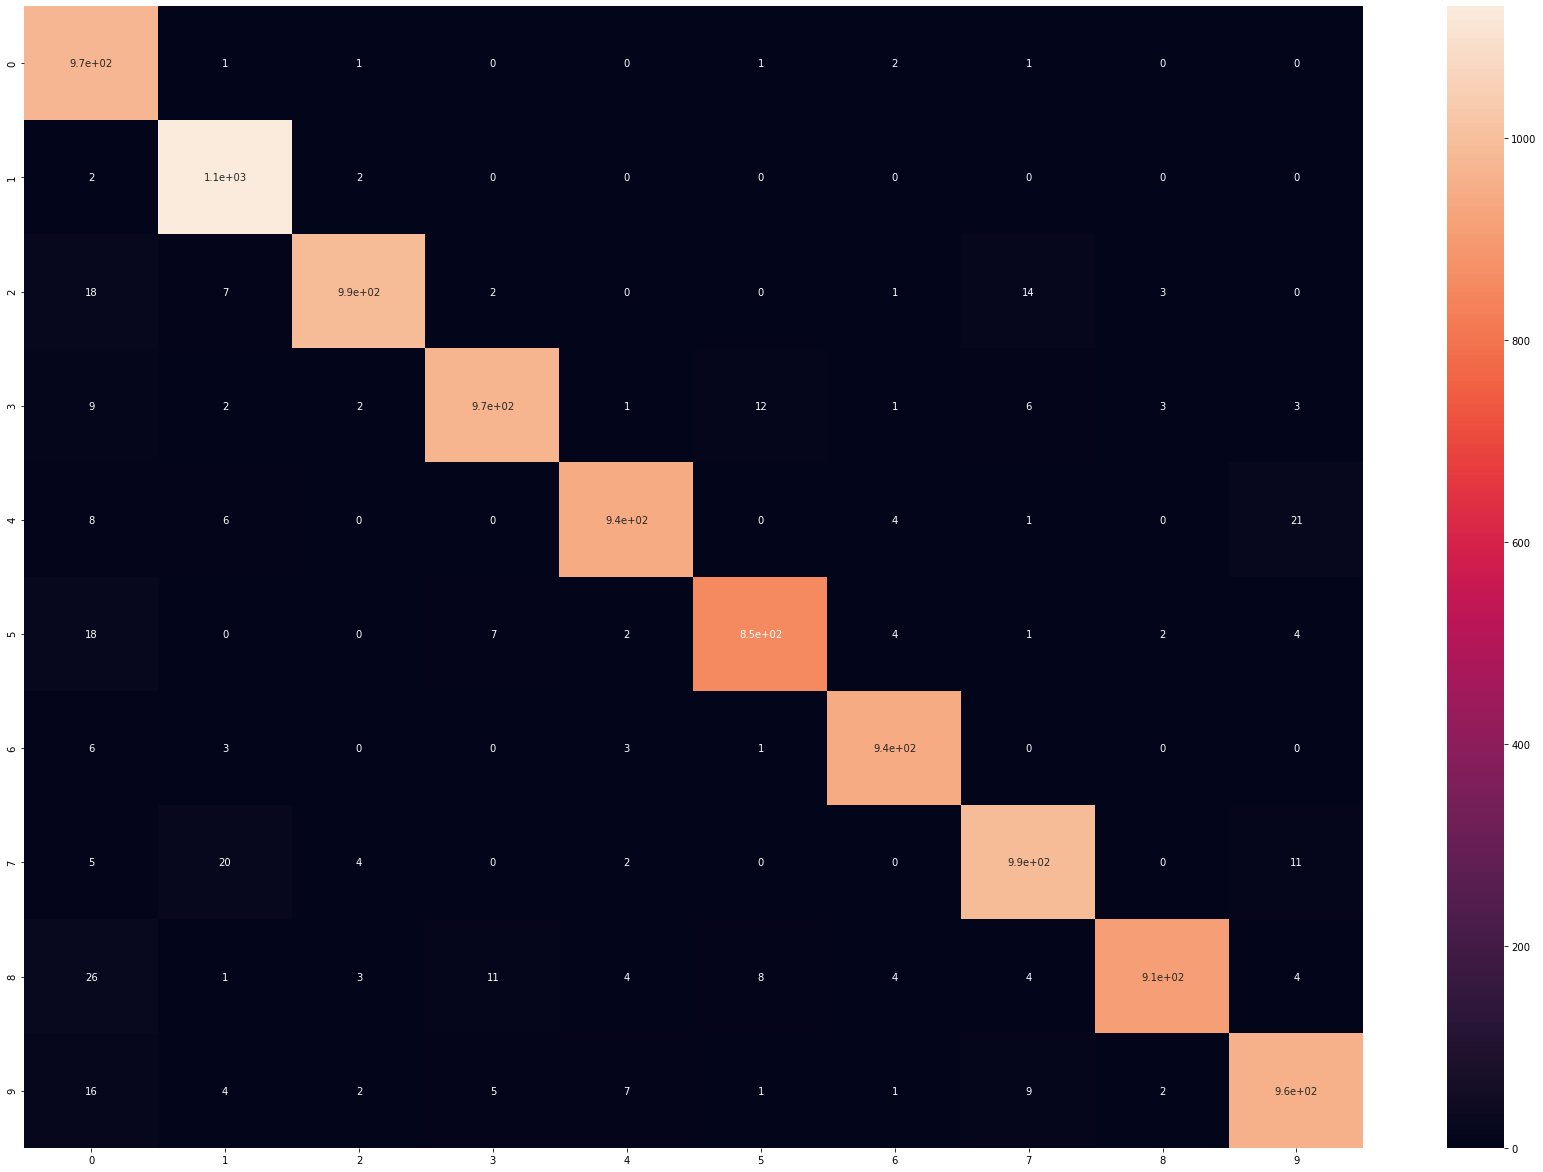

In [9]:
num_axis_labels = '0123456789'

create_confusion(y_test_ohe, knn_predicted, num_axis_labels)

One-vs-One ROC AUC scores:
0.981361 (macro), 
0.981538 (weighted)

One-vs-Rest ROC AUC scores:
0.981361 (macro), 
0.981538 (weighted)


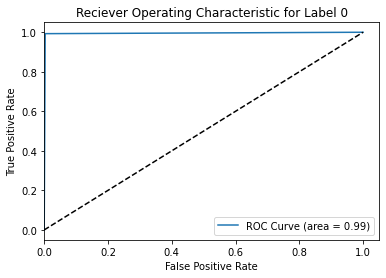

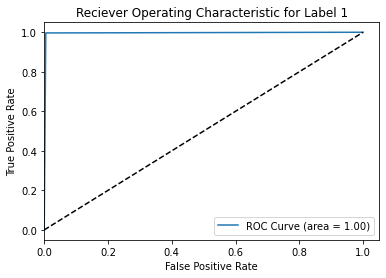

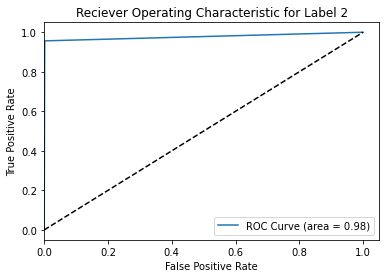

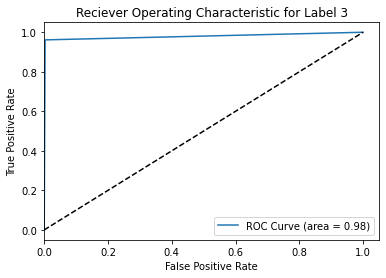

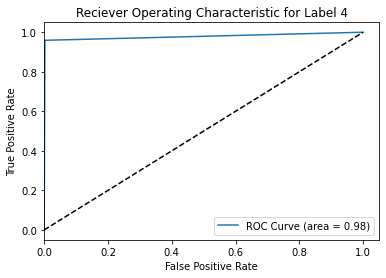

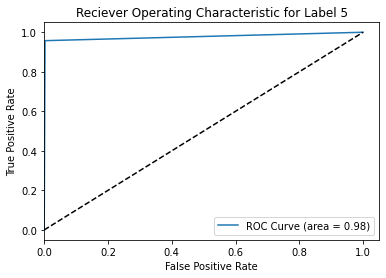

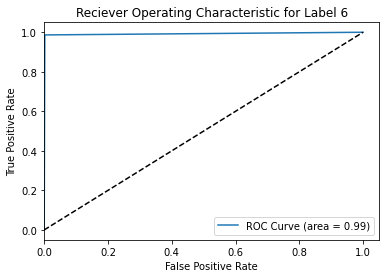

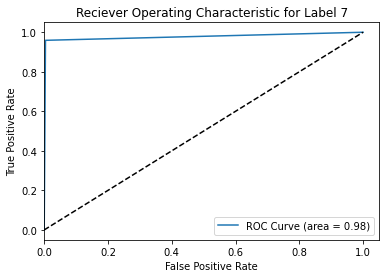

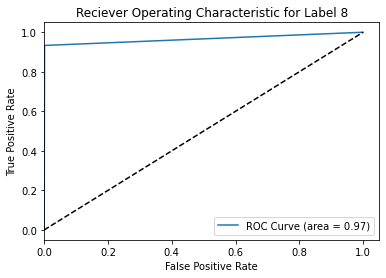

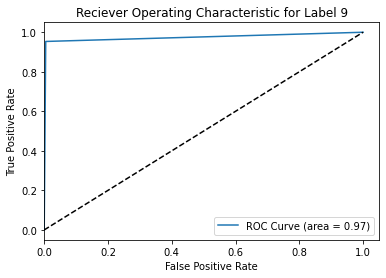

In [10]:
roc_auc(y_test_ohe, knn_predicted, num_classes)

## Random Forest with Digits

In [11]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train_num, y_train_ohe)

RandomForestClassifier()

In [12]:
forest_predicted = random_forest.predict(X_test_num)
print('Accuracy: ', accuracy_score(expected, forest_predicted))

Accuracy:  0.9033


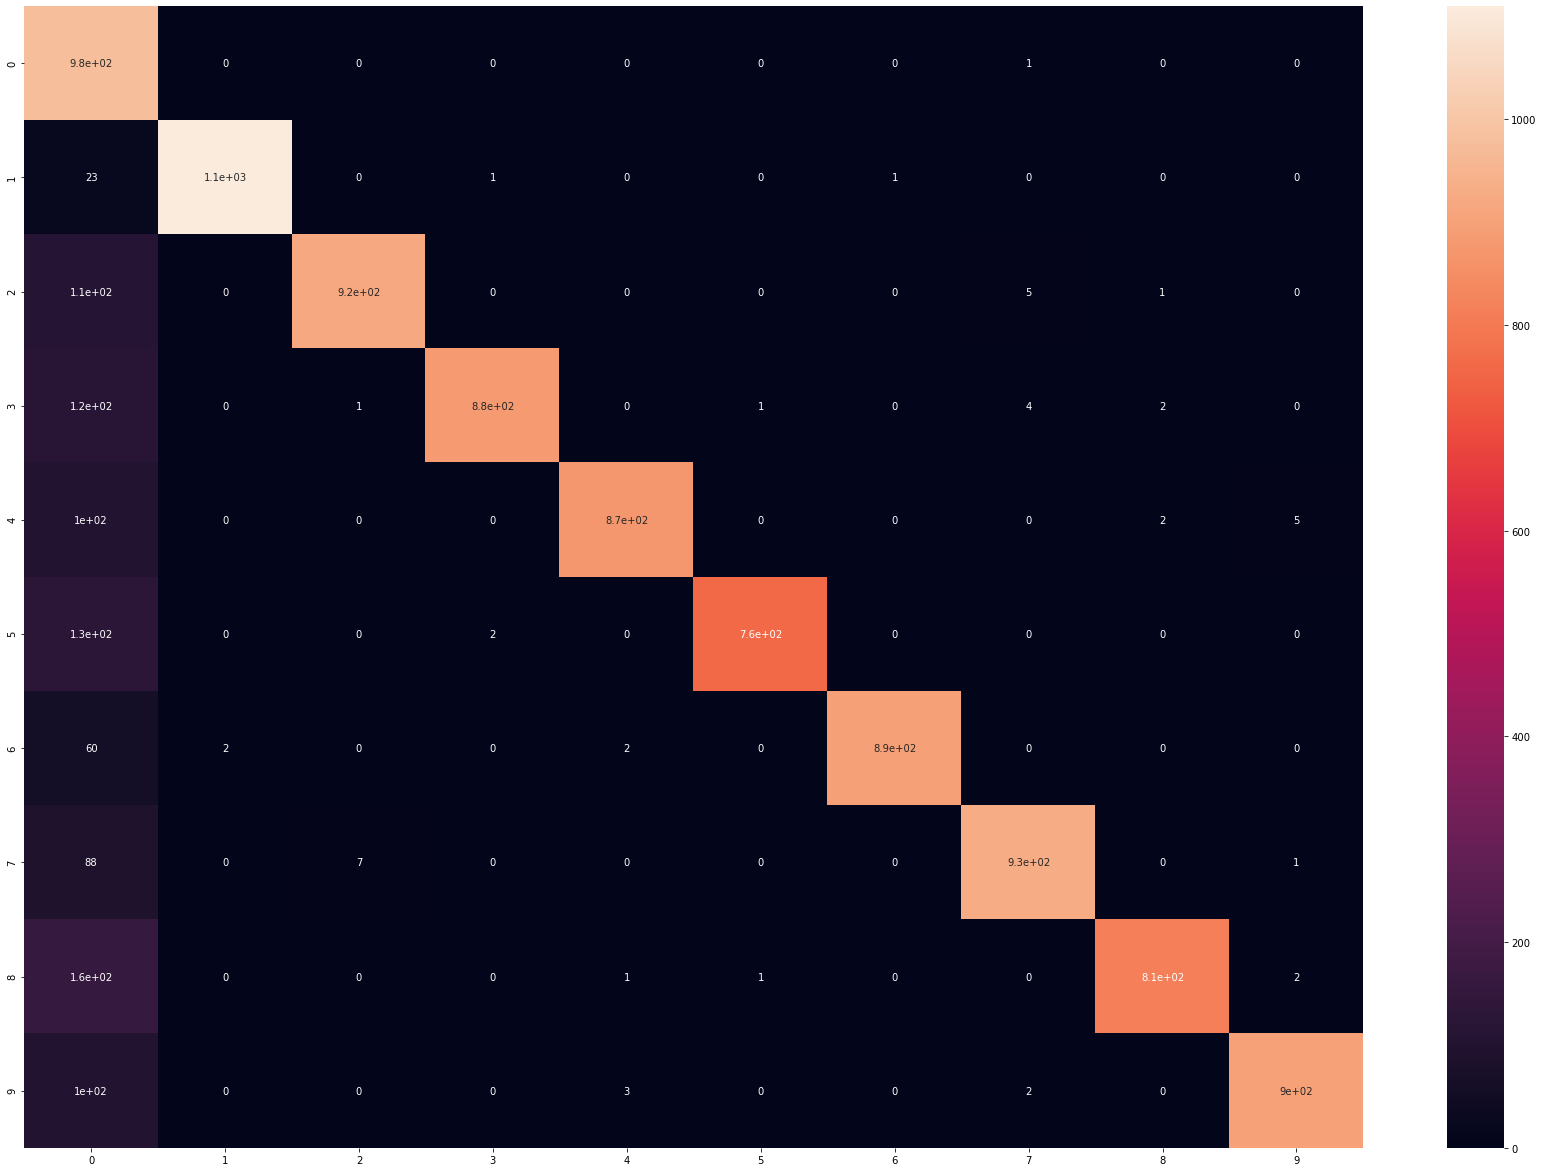

In [13]:
create_confusion(y_test_ohe, forest_predicted, num_axis_labels)

One-vs-One ROC AUC scores:
0.950651 (macro), 
0.951359 (weighted)

One-vs-Rest ROC AUC scores:
0.950651 (macro), 
0.951359 (weighted)


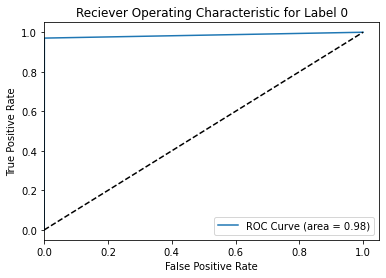

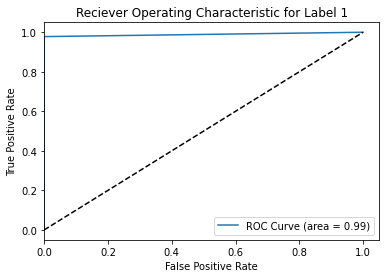

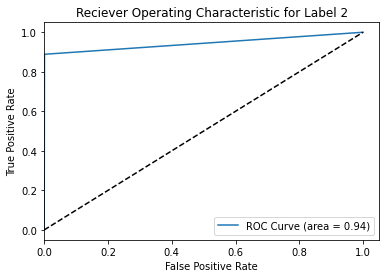

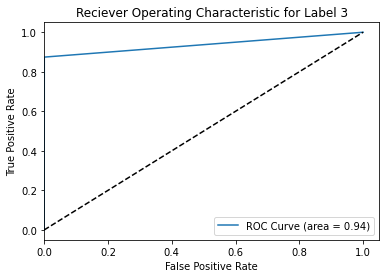

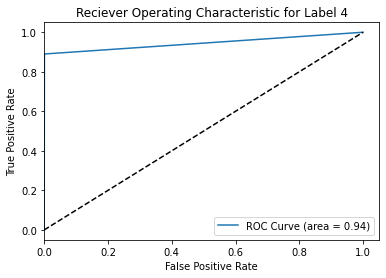

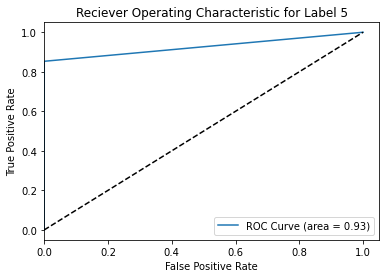

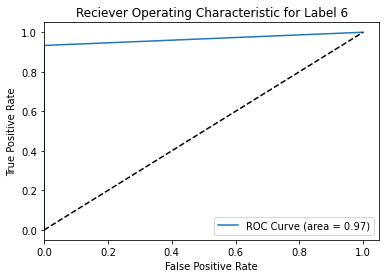

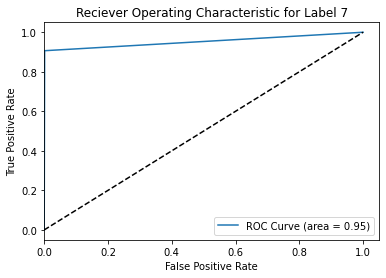

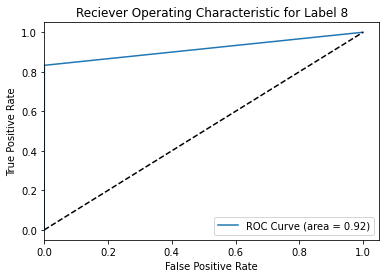

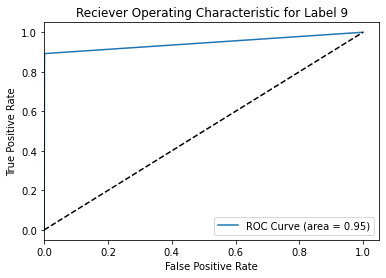

In [14]:
roc_auc(y_test_ohe, forest_predicted, num_classes)

## Linear SVM with Digits

In [15]:
# Linear SVM (due to time consumption of using SVM with large dataset)

from sklearn.svm import LinearSVC

linear_svm = LinearSVC(max_iter=10000)
linear_svm.fit(X_train_num, y_train_num) # Does not take one-hot-encoded labels

LinearSVC(max_iter=10000)

In [16]:
linsvm_predicted = linear_svm.predict(X_test_num)
print('Accuracy: ', accuracy_score(np.argmax(expected, axis=1), linsvm_predicted))

Accuracy:  0.9183


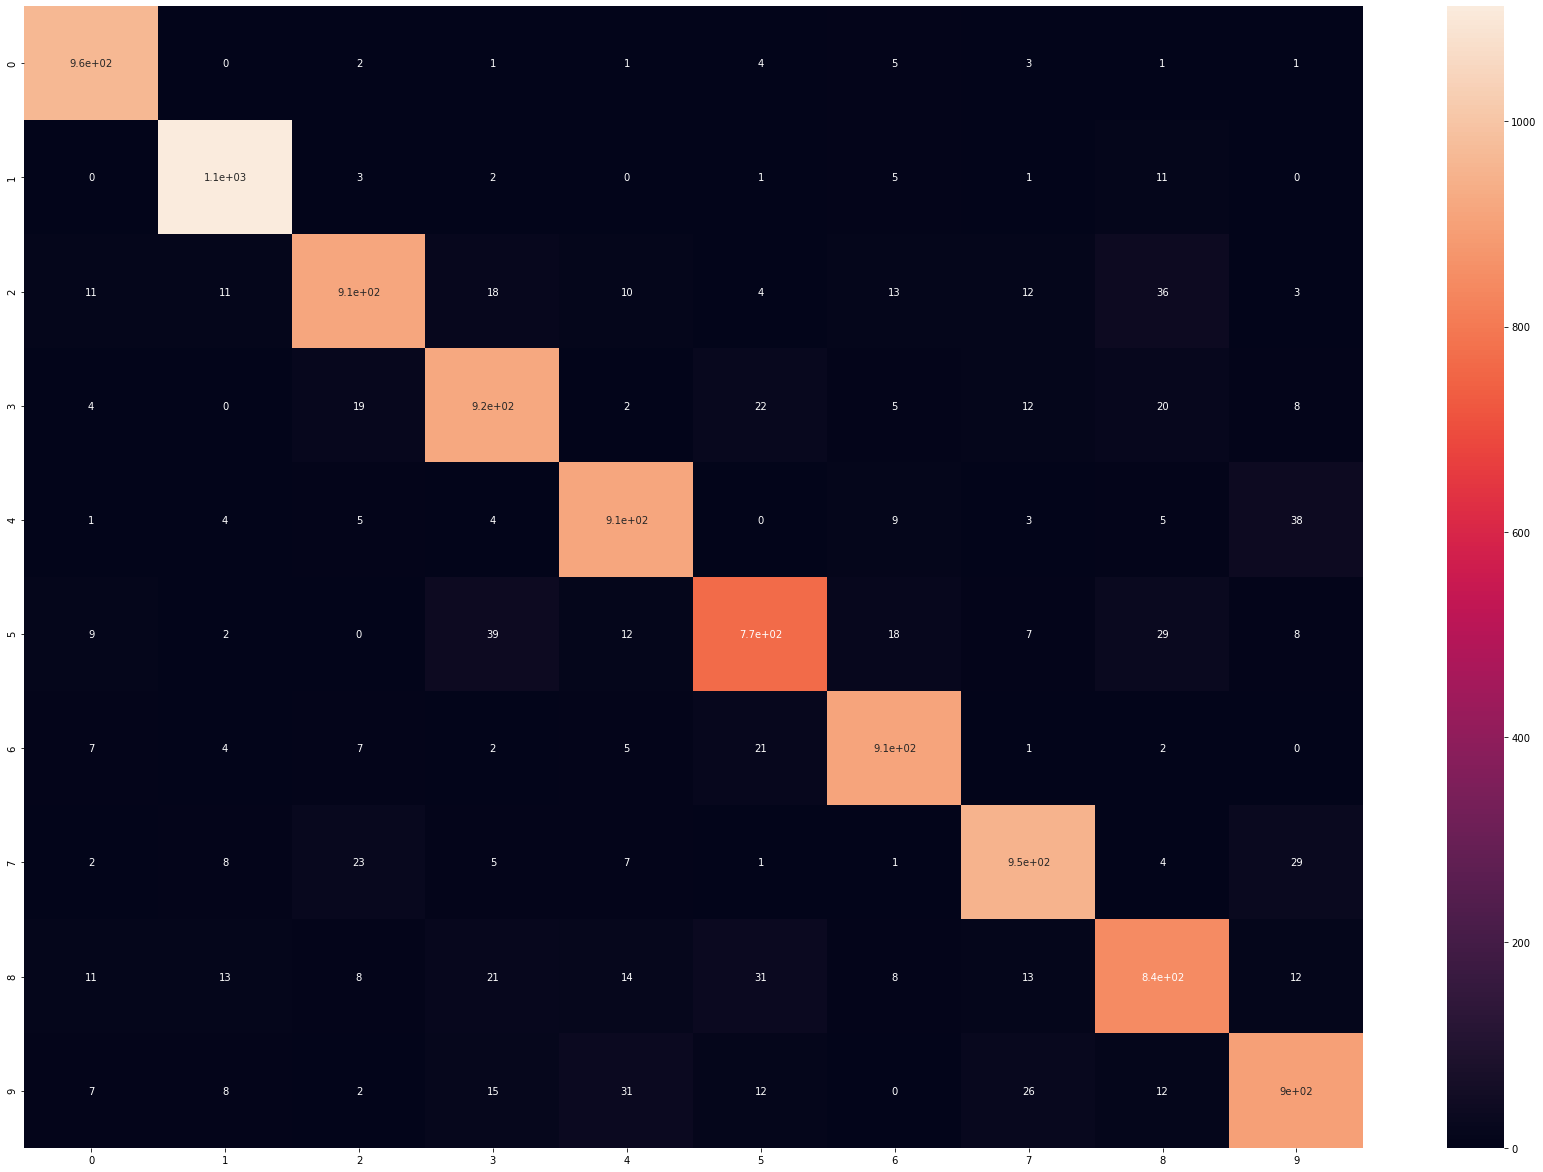

In [17]:
linsvm_predicted_ohe = np_utils.to_categorical(linsvm_predicted)

create_confusion(y_test_ohe, linsvm_predicted_ohe, num_axis_labels)

One-vs-One ROC AUC scores:
0.954024 (macro), 
0.954644 (weighted)

One-vs-Rest ROC AUC scores:
0.954024 (macro), 
0.954644 (weighted)


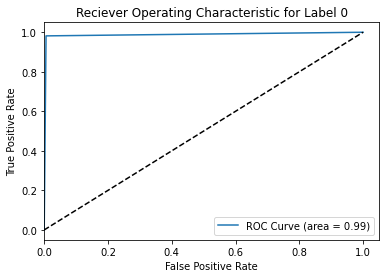

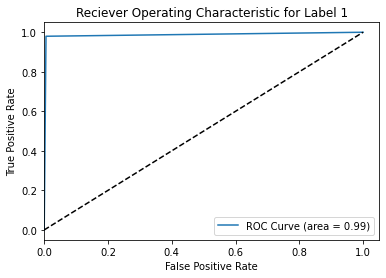

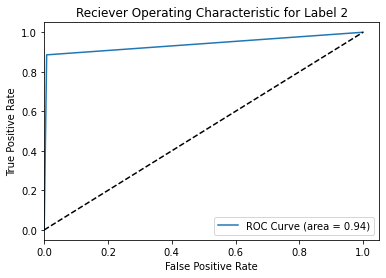

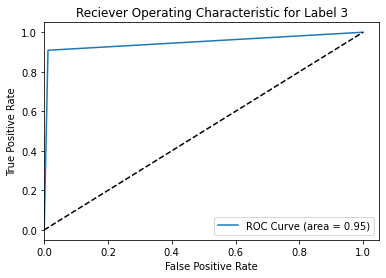

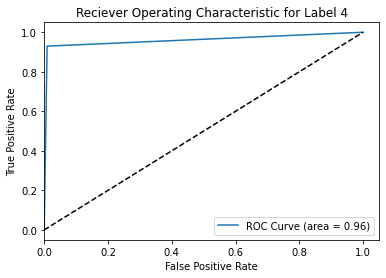

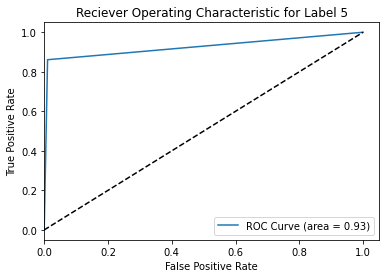

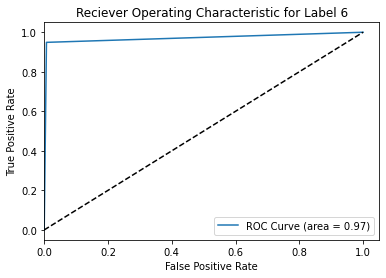

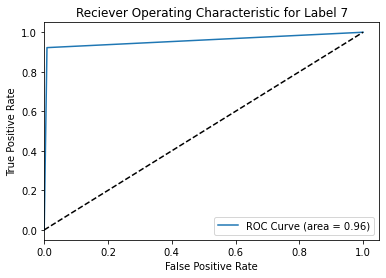

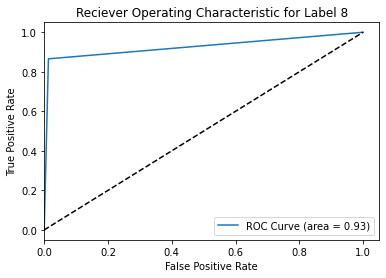

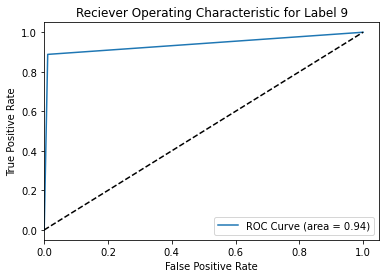

In [18]:
roc_auc(y_test_ohe, linsvm_predicted_ohe, num_classes)

## Logistic Regression with Digits

In [19]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_num, y_train_num)

LogisticRegression(max_iter=1000)

In [20]:
logreg_predicted = logreg.predict(X_test_num)
print('Accuracy: ', accuracy_score(np.argmax(expected, axis=1), logreg_predicted))

Accuracy:  0.9256


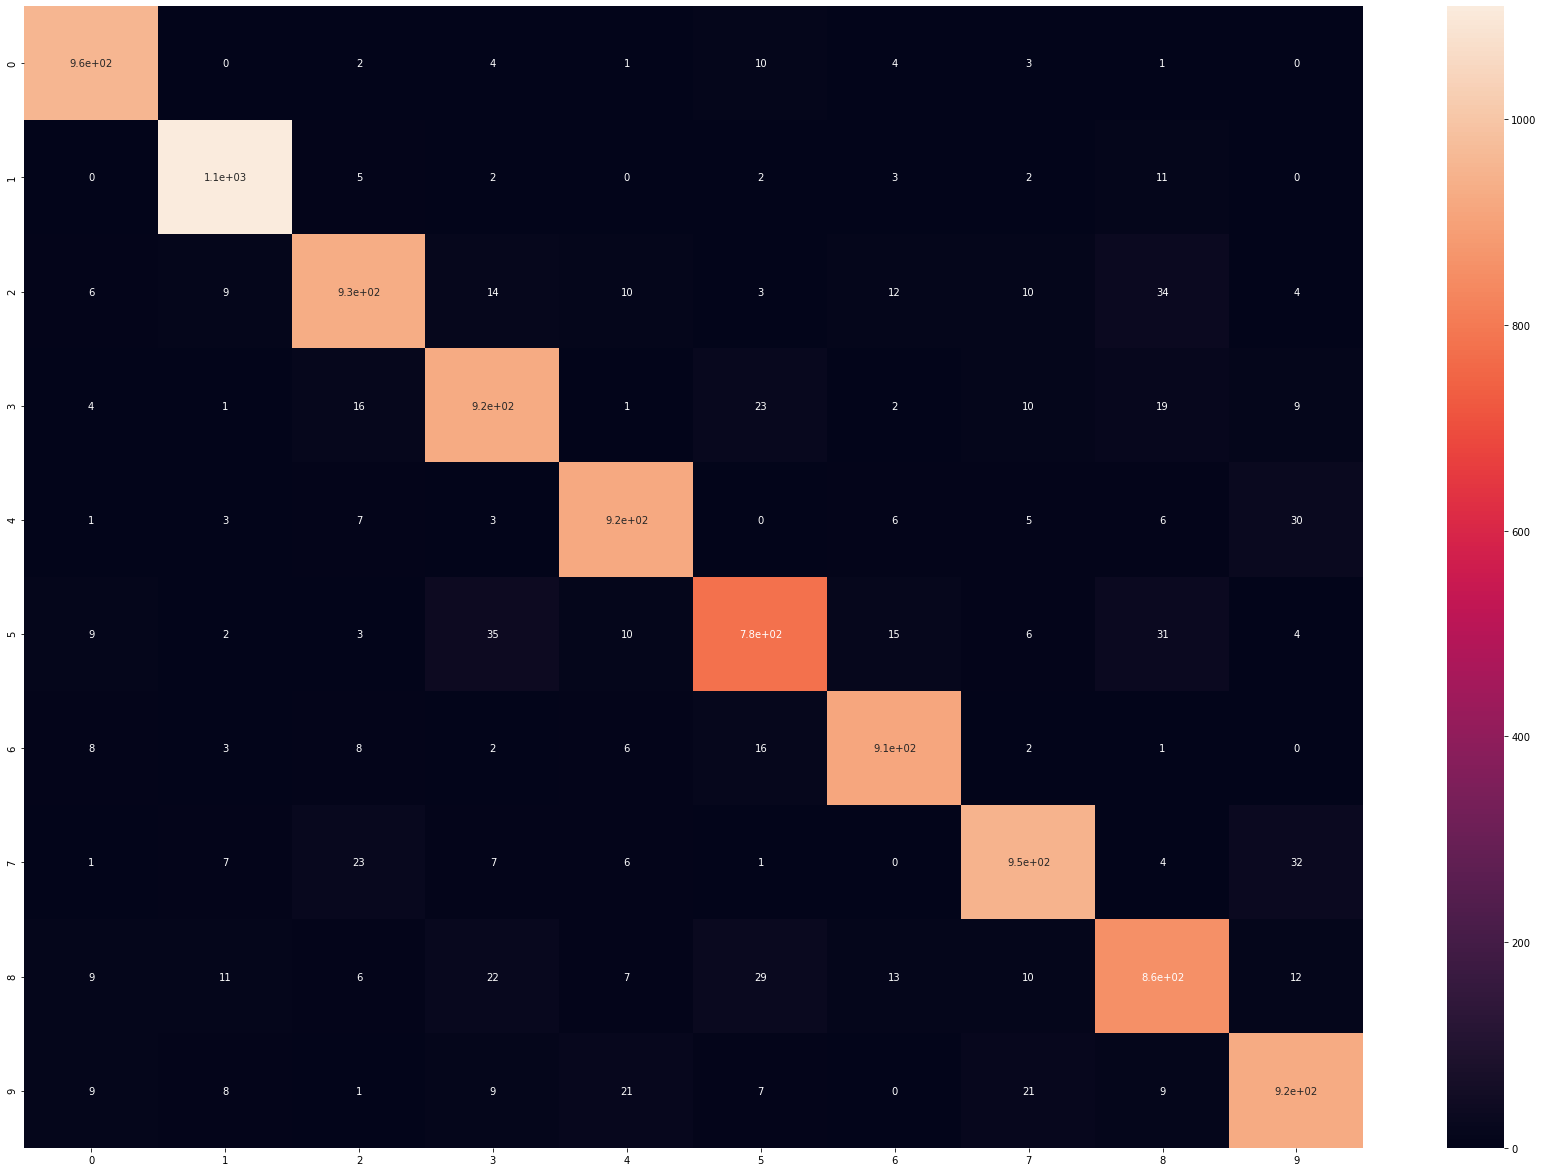

In [21]:
logreg_predicted_ohe = np_utils.to_categorical(logreg_predicted)

create_confusion(y_test_ohe, logreg_predicted_ohe, num_axis_labels)

One-vs-One ROC AUC scores:
0.954024 (macro), 
0.954644 (weighted)

One-vs-Rest ROC AUC scores:
0.954024 (macro), 
0.954644 (weighted)


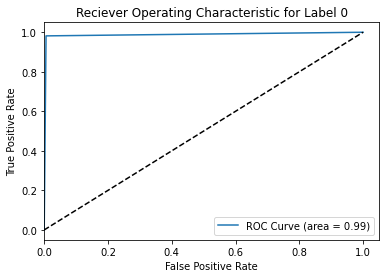

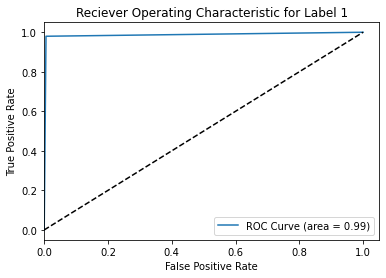

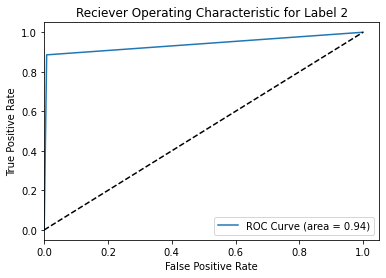

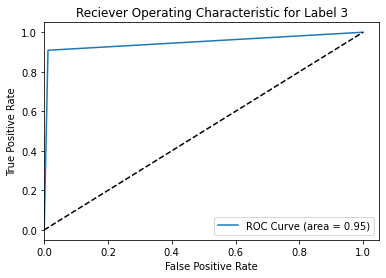

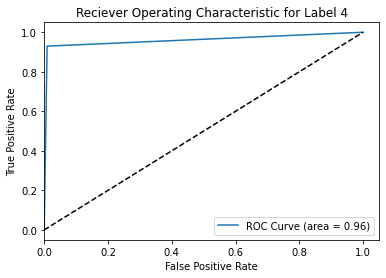

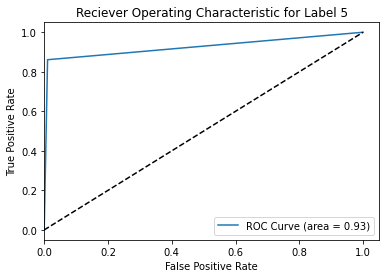

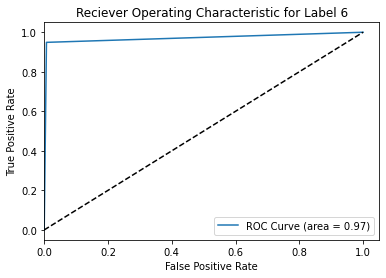

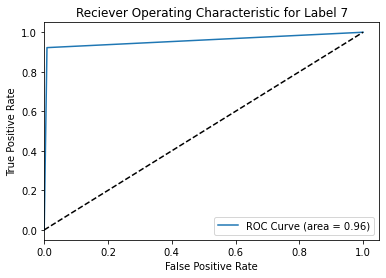

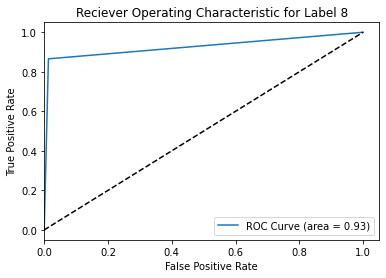

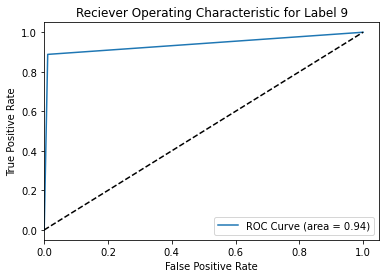

In [22]:
roc_auc(y_test_ohe, linsvm_predicted_ohe, num_classes)

## Simple Neural Network with Digits

In [42]:
# Simple Neural Network

from keras.models import Sequential
from keras.layers import Dense

def simple_nn(num_classes):
    model = Sequential()
    
    # Single hidden layer with neurons equivalent to number of pixels input
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    
    # Output Layer
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
model = simple_nn(num_classes)
model.fit(X_train_num, y_train_ohe, validation_data=(X_test_num, y_test_ohe), epochs=10, batch_size=200, verbose=2)

accuracy = model.evaluate(X_test_num, y_test_ohe, verbose=0)
print('Accuracy: ', accuracy[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 3s - loss: 0.2764 - accuracy: 0.9210 - val_loss: 0.1391 - val_accuracy: 0.9587
Epoch 2/10
 - 3s - loss: 0.1111 - accuracy: 0.9683 - val_loss: 0.0939 - val_accuracy: 0.9711
Epoch 3/10
 - 3s - loss: 0.0706 - accuracy: 0.9794 - val_loss: 0.0772 - val_accuracy: 0.9765
Epoch 4/10
 - 3s - loss: 0.0498 - accuracy: 0.9859 - val_loss: 0.0751 - val_accuracy: 0.9763
Epoch 5/10
 - 3s - loss: 0.0363 - accuracy: 0.9902 - val_loss: 0.0594 - val_accuracy: 0.9811
Epoch 6/10
 - 3s - loss: 0.0266 - accuracy: 0.9929 - val_loss: 0.0630 - val_accuracy: 0.9802
Epoch 7/10
 - 3s - loss: 0.0195 - accuracy: 0.9950 - val_loss: 0.0635 - val_accuracy: 0.9811
Epoch 8/10
 - 3s - loss: 0.0140 - accuracy: 0.9971 - val_loss: 0.0608 - val_accuracy: 0.9813
Epoch 9/10
 - 3s - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.0565 - val_accuracy: 0.9835
Epoch 10/10
 - 3s - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.0612 - val_accuracy: 0.9820
Accuracy:  0.981999

In [25]:
nn_predicted = model.predict(X_test_num, batch_size=200, verbose=2)
print('Accuracy: ', accuracy_score(np.argmax(expected, axis=1), np.argmax(nn_predicted, axis=1)))

Accuracy:  0.982


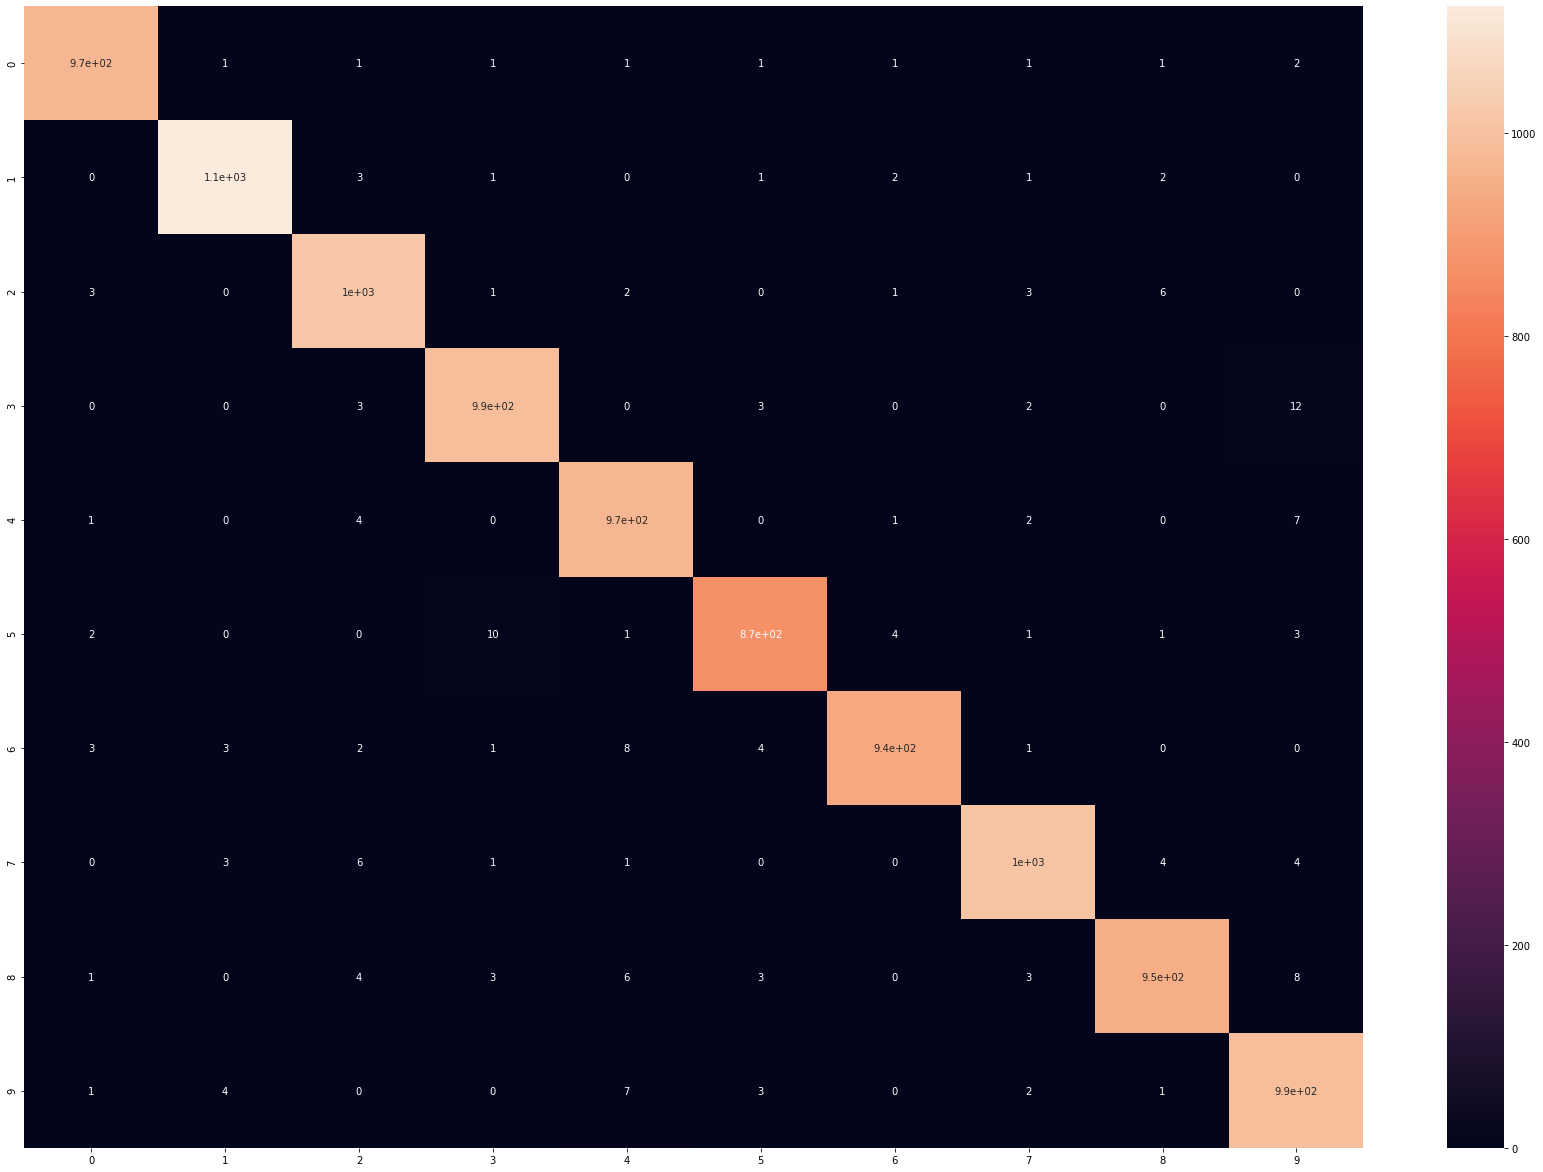

In [26]:
create_confusion(y_test_ohe, nn_predicted, num_axis_labels)

One-vs-One ROC AUC scores:
0.999750 (macro), 
0.999751 (weighted)

One-vs-Rest ROC AUC scores:
0.999750 (macro), 
0.999751 (weighted)


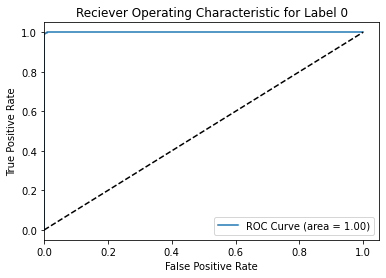

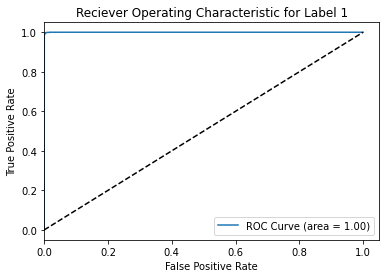

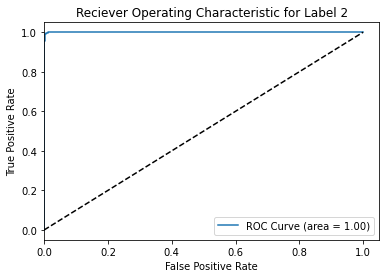

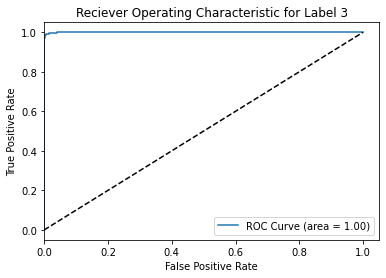

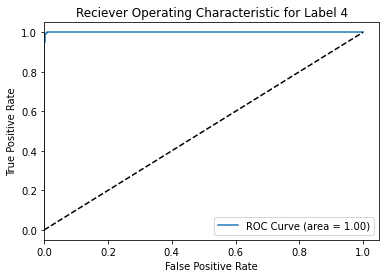

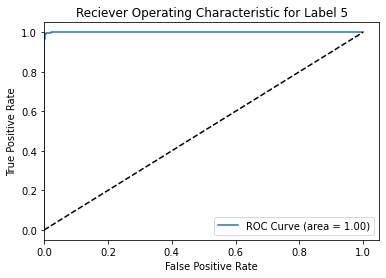

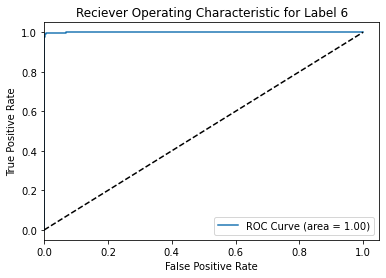

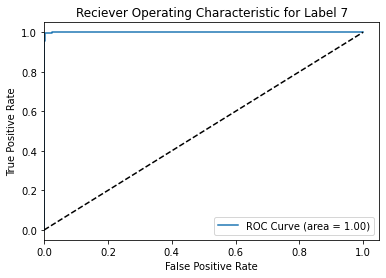

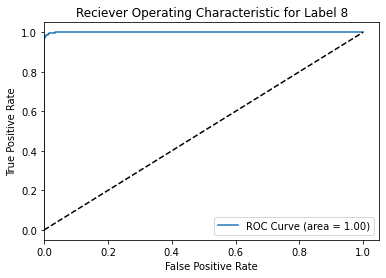

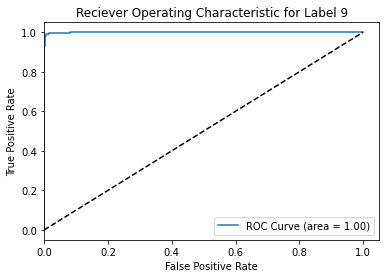

In [27]:
roc_auc(y_test_ohe, nn_predicted, num_classes)

# Letter Data

In [ ]:
# TODO: Test classifiers using just letter data
# Refactor roc_auc() to work with just letter data

In [8]:
letter_df = pd.read_csv('emnist-letters-train.csv')
letter_df

23  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.406  0.407  \
0       7  0    0    0    0    0    0    0    0    0  ...      0      0   
1      16  0    0    0    0    0    0    0    0    0  ...      0      0   
2      15  0    0    0    0    0    0    0    0    0  ...      0      0   
3      23  0    0    0    0    0    0    0    0    0  ...      0      0   
4      17  0    0    0    0    0    0    0    0    0  ...      0      0   
...    .. ..  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
88794   1  0    0    0    0    0    0    0    0    0  ...      0      0   
88795  21  0    0    0    0    0    0    0    0    0  ...      0      0   
88796   1  0    0    0    0    0    0    0    0    0  ...      0      0   
88797  23  0    0    0    0    0    0    0    0    0  ...      0      0   
88798  12  0    0    0    0    0    0    0    0    0  ...      0      0   

       0.408  0.409  0.410  0.411  0.412  0.413  0.414  0.415  
0          0      0      0      0      0      0      0      0  
1          0      0      0      0      0      0      0      0  
2          0      0      0      0      0      0      0      0  
3          0      0      0      0      0      0      0      0  
4          0      0      0      0      0      0      0      0  
...      ...    ...    ...    ...    ...    ...    ...    ...  
88794      0      0      0      0      0      0      0      0  
88795      0      0      0      0      0      0      0      0  
88796      0      0      0      0      0      0      0      0  
88797      0      0      0      0      0      0      0      0  
88798      0      0      0      0      0      0      0      0  

[88799 rows x 785 columns]

In [9]:
letter_df = letter_df.rename(columns={'23': 'Label'})
a = letter_df.columns[np.arange(1, 785)]
b = [i for i in range(len(a))]
d = dict(zip(a, b))
letter_df = letter_df.rename(columns=d)
letter_df

Label  0  1  2  3  4  5  6  7  8  ...  774  775  776  777  778  779  \
0          7  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
1         16  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
2         15  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
3         23  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
4         17  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
...      ... .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...   
88794      1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88795     21  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88796      1  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88797     23  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   
88798     12  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0   

       780  781  782  783  
0        0    0    0    0  
1        0    0    0    0  
2        0    0    0    0  
3        0    0    0    0  
4        0    0    0    0  
...    ...  ...  ...  ...  
88794    0    0    0    0  
88795    0    0    0    0  
88796    0    0    0    0  
88797    0    0    0    0  
88798    0    0    0    0  

[88799 rows x 785 columns]

In [10]:
np.unique(letter_df['Label'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64)

In [11]:
letter_df['Label'] = letter_df['Label'] - 1

np.unique(letter_df['Label'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64)

In [12]:
y_letter = letter_df['Label']
X_letter = letter_df.drop(['Label'], axis=1)

y_letter

0         6
1        15
2        14
3        22
4        16
         ..
88794     0
88795    20
88796     0
88797    22
88798    11
Name: Label, Length: 88799, dtype: int64

In [13]:
X_letter

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
0        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
88794    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88795    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88796    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88797    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
88798    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

       777  778  779  780  781  782  783  
0        0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
88794    0    0    0    0    0    0    0  
88795    0    0    0    0    0    0    0  
88796    0    0    0    0    0    0    0  
88797    0    0    0    0    0    0    0  
88798    0    0    0    0    0    0    0  

[88799 rows x 784 columns]

In [14]:
from sklearn.model_selection import train_test_split
X_train_letter, X_test_letter, y_train_letter, y_test_letter = train_test_split(X_letter, y_letter, test_size=.33)

X_train_letter

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
35384    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
14957    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
62153    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
15253    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
76621    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
72744    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
58358    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
36227    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
36094    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
64979    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

       777  778  779  780  781  782  783  
35384    0    0    0    0    0    0    0  
14957    0    0    0    0    0    0    0  
62153    0    0    0    0    0    0    0  
15253    0    0    0    0    0    0    0  
76621    0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
72744    0    0    0    0    0    0    0  
58358    0    0    0    0    0    0    0  
36227    0    0    0    0    0    0    0  
36094    0    0    0    0    0    0    0  
64979    0    0    0    0    0    0    0  

[59495 rows x 784 columns]

In [15]:
y_train_letter

35384     8
14957     5
62153     2
15253     1
76621     5
         ..
72744    23
58358     4
36227     3
36094    21
64979    19
Name: Label, Length: 59495, dtype: int64

In [16]:
X_test_letter

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
33701    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
39269    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
77462    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
14589    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
38198    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
82785    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
41694    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
77154    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
73805    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
30384    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   

       777  778  779  780  781  782  783  
33701    0    0    0    0    0    0    0  
39269    0    0    0    0    0    0    0  
77462    0    0    0    0    0    0    0  
14589    0    0    0    0    0    0    0  
38198    0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
82785    0    0    0    0    0    0    0  
41694    0    0    0    0    0    0    0  
77154    0    0    0    0    0    0    0  
73805    0    0    0    0    0    0    0  
30384    0    0    0    0    0    0    0  

[29304 rows x 784 columns]

In [17]:
y_test_letter

33701    13
39269     3
77462    19
14589    18
38198    23
         ..
82785     7
41694     7
77154    12
73805    20
30384     5
Name: Label, Length: 29304, dtype: int64

In [18]:
X_train_letter = np.array(X_train_letter.iloc[:, 0:].values)
y_train_letter = np.array(y_train_letter)

X_test_letter = np.array(X_test_letter.iloc[:, 0:].values)
y_test_letter = np.array(y_test_letter)

X_train_letter = X_train_letter / 255
X_test_letter = X_test_letter / 255

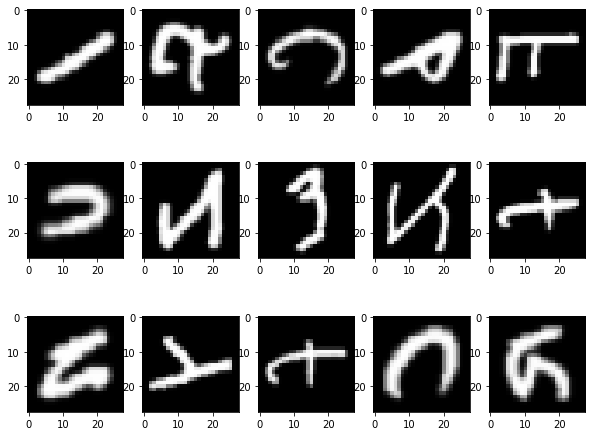

In [19]:
fig, axes = plt.subplots(3, 5, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_letter[i].reshape([28,28]), cmap=plt.get_cmap('gray'))

In [20]:
num_classes = 26
y_train_letter_ohe = np_utils.to_categorical(y_train_letter, num_classes)
y_test_letter_ohe = np_utils.to_categorical(y_test_letter, num_classes)

In [29]:
y_test_letter_ohe.shape

(29304, 26)

## K-Nearest Neighbors with Letters

In [21]:
knn = KNeighborsClassifier()
knn.fit(X_train_letter, y_train_letter_ohe)

KNeighborsClassifier()

In [22]:
knn_predicted = knn.predict(X_test_letter)

In [25]:
print('Accuracy: ', accuracy_score(y_test_letter_ohe, knn_predicted))

Accuracy:  0.8224133224133224


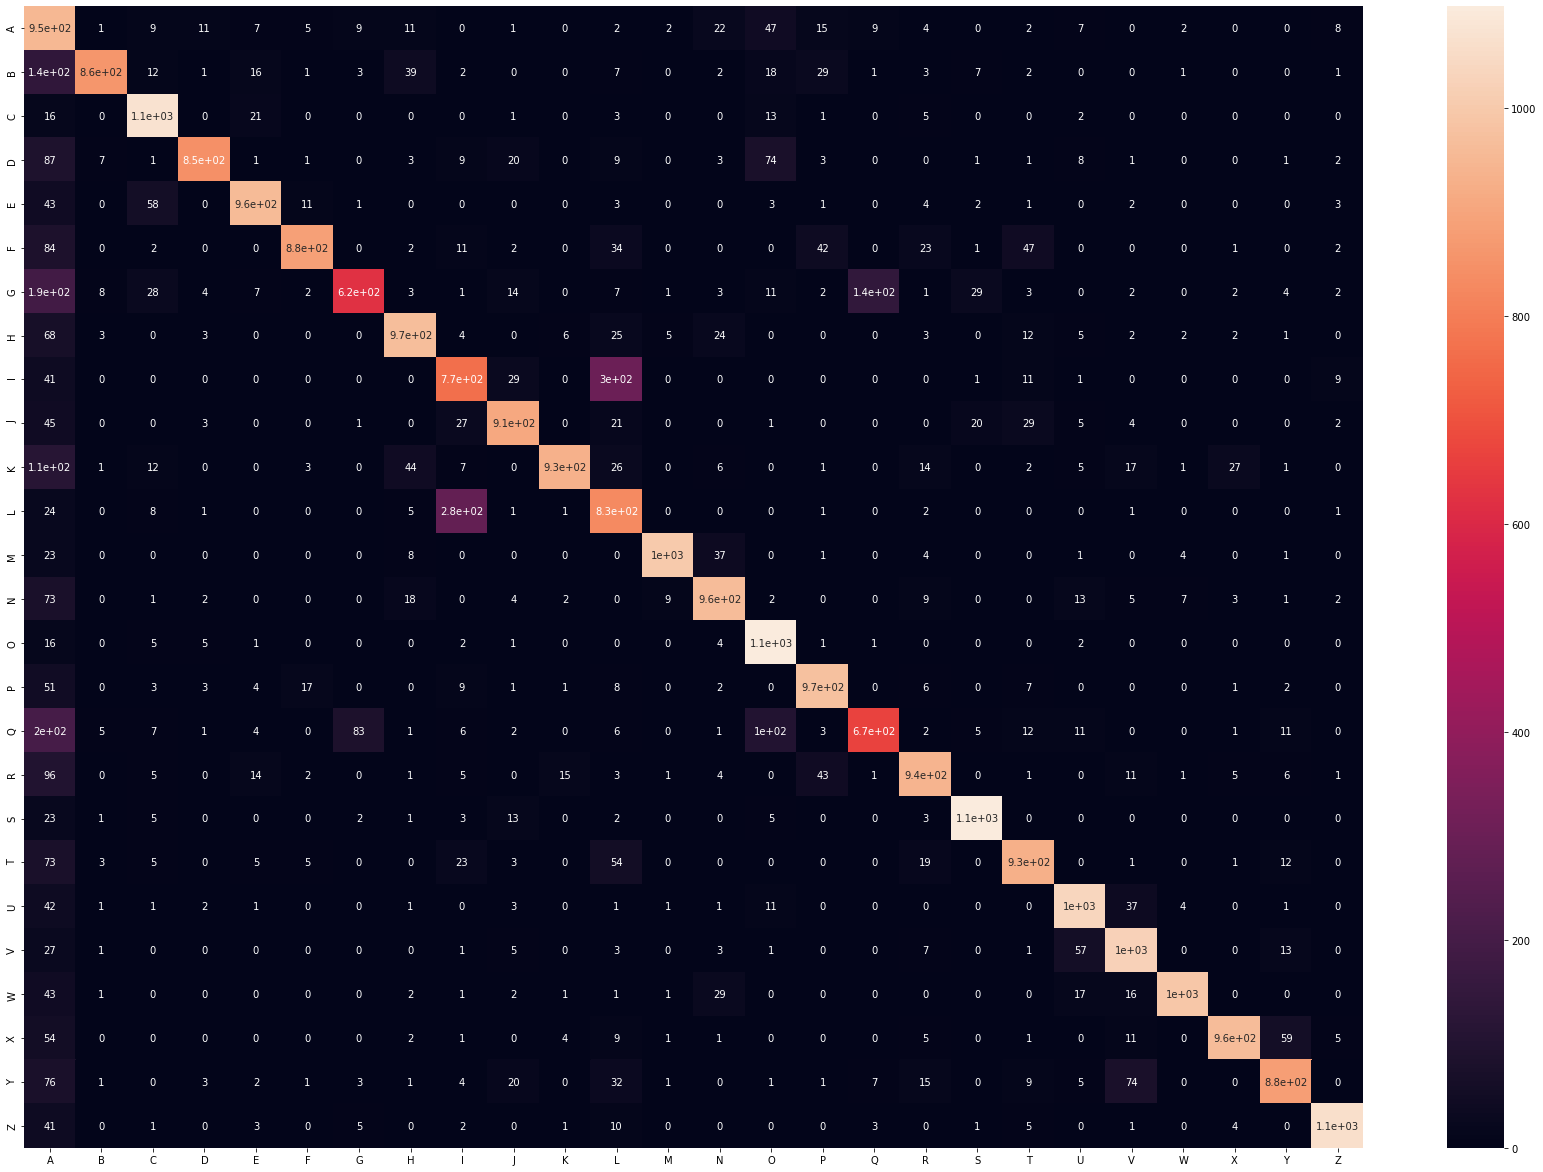

In [31]:
letter_axis_labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

create_confusion(y_test_letter_ohe, knn_predicted, letter_axis_labels)

In [ ]:
## TODO: roc-auc after refactor

## Logistic Regression with Letters

In [36]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_letter, y_train_letter)

LogisticRegression(max_iter=10000)

In [37]:
logreg_predicted = logreg.predict(X_test_letter)
print('Accuracy: ', accuracy_score(y_test_letter, logreg_predicted))

Accuracy:  0.7093570843570843


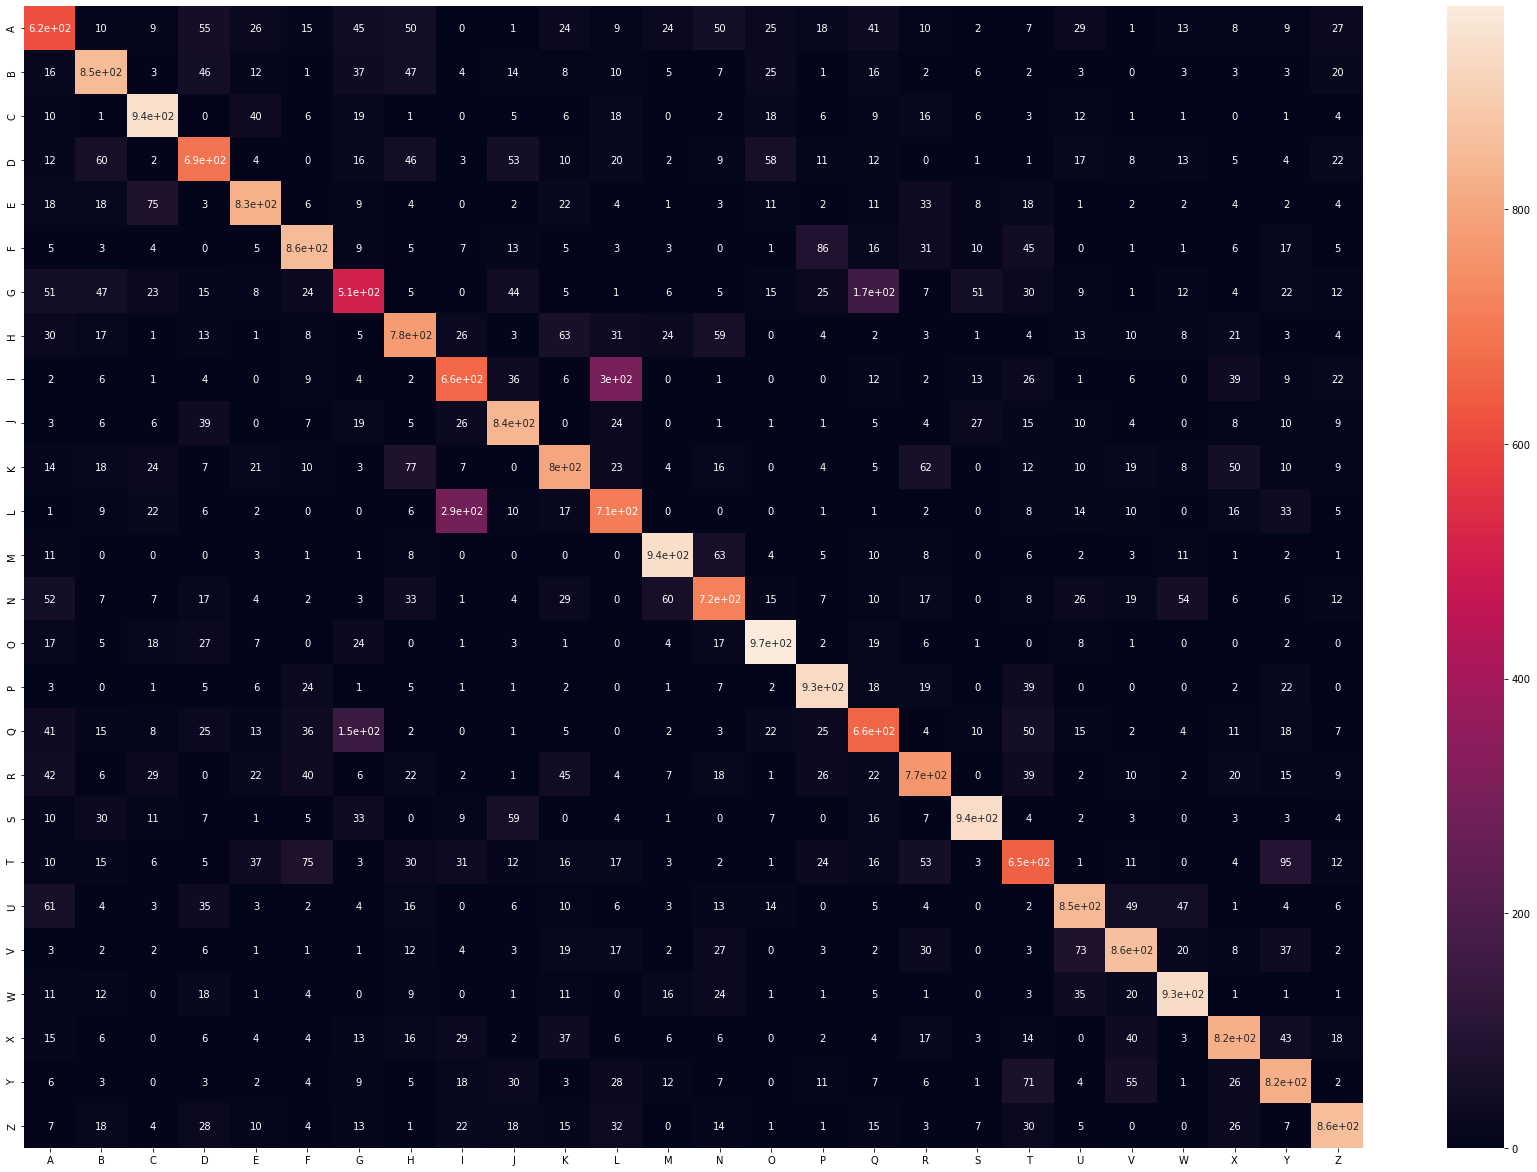

In [40]:
logreg_predicted_ohe = np_utils.to_categorical(logreg_predicted)

create_confusion(y_test_letter_ohe, logreg_predicted_ohe, letter_axis_labels)

## Simple Neural Network with Letters

In [43]:
model = simple_nn(num_classes)
model.fit(X_train_letter, y_train_letter_ohe, validation_data=(X_test_letter, y_test_letter_ohe), 
          epochs=10, batch_size=200, verbose=2)

accuracy = model.evaluate(X_test_letter, y_test_letter_ohe, verbose=0)
print('Accuracy: ', accuracy[1])

Train on 59495 samples, validate on 29304 samples
Epoch 1/10
 - 4s - loss: 0.9432 - accuracy: 0.7290 - val_loss: 0.6030 - val_accuracy: 0.8189
Epoch 2/10
 - 4s - loss: 0.4842 - accuracy: 0.8546 - val_loss: 0.4449 - val_accuracy: 0.8635
Epoch 3/10
 - 4s - loss: 0.3625 - accuracy: 0.8897 - val_loss: 0.3980 - val_accuracy: 0.8753
Epoch 4/10
 - 4s - loss: 0.3032 - accuracy: 0.9047 - val_loss: 0.3583 - val_accuracy: 0.8877
Epoch 5/10
 - 4s - loss: 0.2533 - accuracy: 0.9193 - val_loss: 0.3592 - val_accuracy: 0.8876
Epoch 6/10
 - 4s - loss: 0.2234 - accuracy: 0.9266 - val_loss: 0.3340 - val_accuracy: 0.8934
Epoch 7/10
 - 4s - loss: 0.1941 - accuracy: 0.9362 - val_loss: 0.3335 - val_accuracy: 0.8936
Epoch 8/10
 - 4s - loss: 0.1721 - accuracy: 0.9434 - val_loss: 0.3342 - val_accuracy: 0.8957
Epoch 9/10
 - 4s - loss: 0.1553 - accuracy: 0.9491 - val_loss: 0.3286 - val_accuracy: 0.8981
Epoch 10/10
 - 4s - loss: 0.1374 - accuracy: 0.9545 - val_loss: 0.3344 - val_accuracy: 0.8977
Accuracy:  0.897693

In [44]:
nn_predicted = model.predict(X_test_letter, batch_size=200, verbose=2)
print('Accuracy: ', accuracy_score(y_test_letter, np.argmax(nn_predicted, axis=1)))

Accuracy:  0.8976931476931477


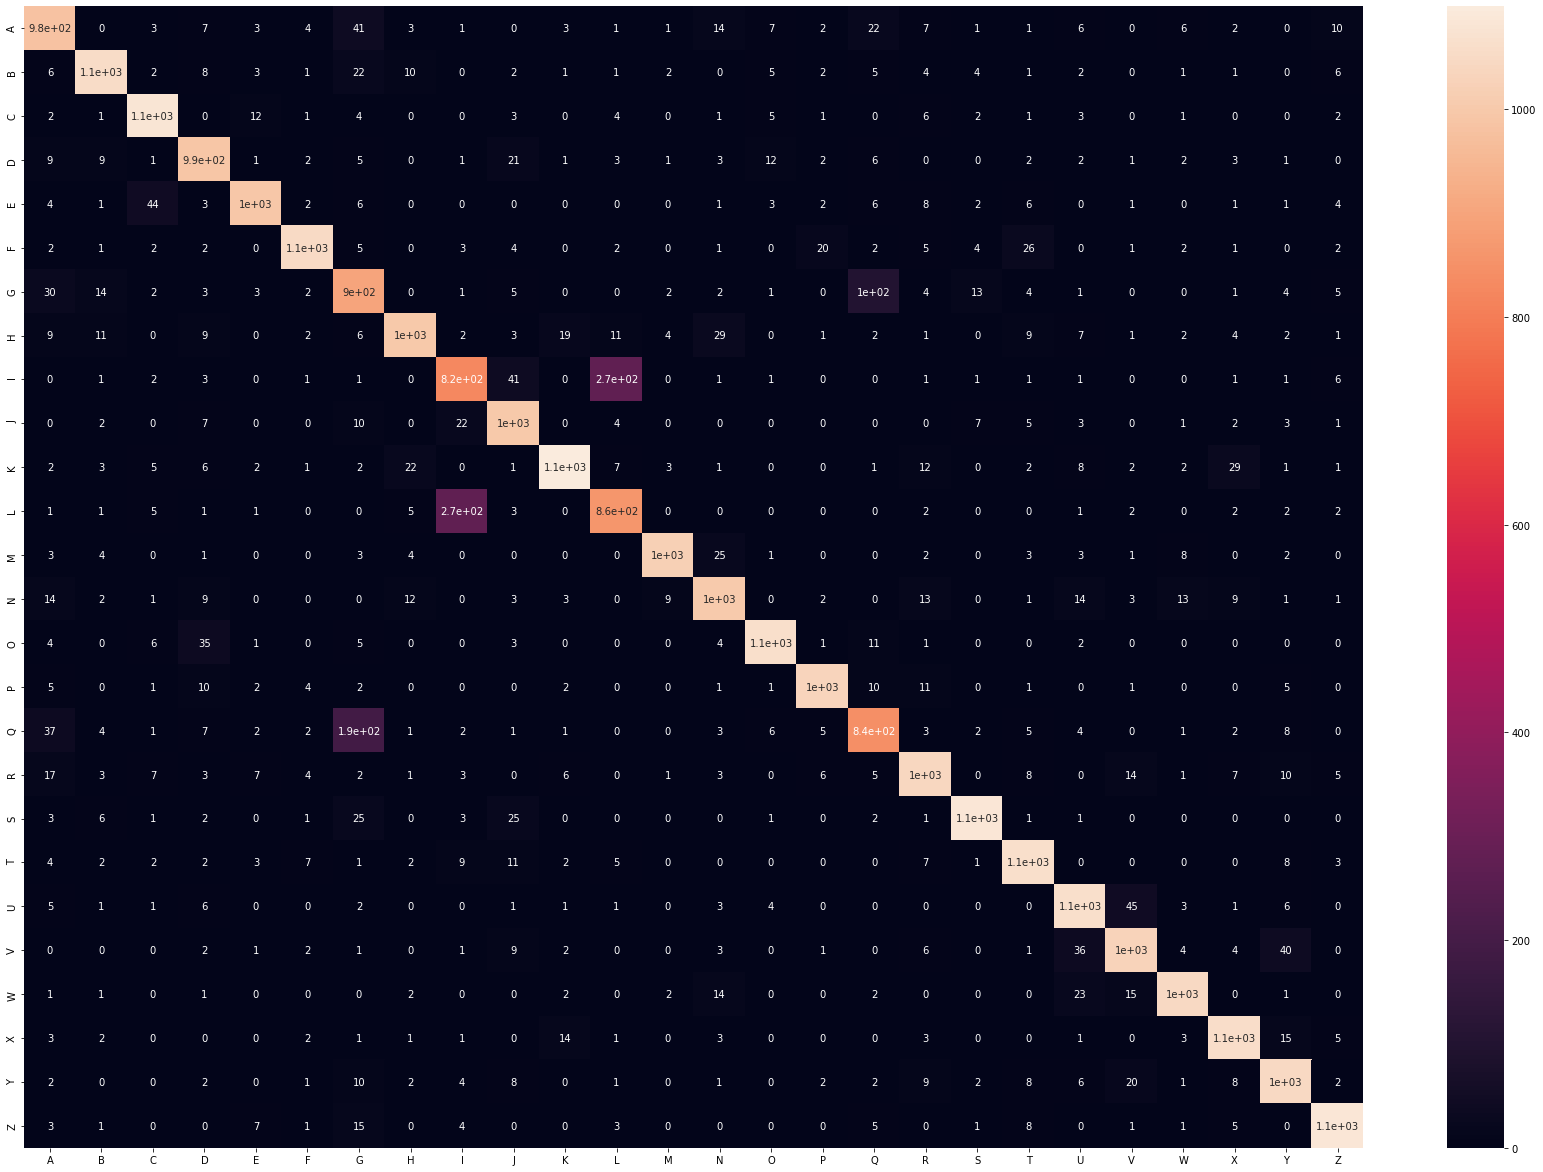

In [45]:
create_confusion(y_test_letter_ohe, nn_predicted, letter_axis_labels)

# Letter and Digit Data

In [32]:
X_train_num = X_train_num * 255

num_df = pd.DataFrame(X_train_num)
num_df['Label'] = y_train_num
first_col = num_df.pop('Label')
num_df.insert(0, 'Label', first_col)
num_df

Label    0    1    2    3    4    5    6    7    8  ...  774  775  776  \
0          5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2          4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3          1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4          9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59995      8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59996      3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59997      5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59998      6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59999      8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
59995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[60000 rows x 785 columns]

In [33]:
df = pd.concat([num_df, letter_df])
df

Label    0    1    2    3    4    5    6    7    8  ...  774  775  776  \
0          5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1          0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2          4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3          1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4          9  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
88794     10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88795     30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88796     10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88797     32  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88798     21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
88794  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88795  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88796  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88797  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88798  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[148799 rows x 785 columns]

In [34]:
y = df.pop('Label')
X = df

X

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
88794  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88795  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88796  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88797  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
88798  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
88794  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88795  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88796  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88797  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
88798  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[148799 rows x 784 columns]

In [35]:
y

0         5
1         0
2         4
3         1
4         9
         ..
88794    10
88795    30
88796    10
88797    32
88798    21
Name: Label, Length: 148799, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

X_train

0    1    2    3    4    5    6    7    8    9    ...   774  775  776  \
48648  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  80.0  0.0  0.0   
15144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0   
86802  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0   
9179   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0   
53523  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  ...   
86444  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0   
42617  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0   
17567  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0   
54608  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0   
2067   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0   

       777  778  779  780  781  782  783  
48648  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
15144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
86802  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9179   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
53523  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
86444  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
42617  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
17567  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
54608  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2067   0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[99695 rows x 784 columns]

In [37]:
y_train

48648     7
15144     5
86802    34
9179     16
53523     7
         ..
86444    32
42617     8
17567    11
54608    34
2067     17
Name: Label, Length: 99695, dtype: int64

In [38]:
X_test

0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
27992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
37829  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
29373  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
51150  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
57987  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
12168  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6532   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
75576  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59209  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
76045  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  779  780  781  782  783  
27992  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
37829  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
29373  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
51150  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
57987  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
12168  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
6532   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
75576  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
59209  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
76045  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[49104 rows x 784 columns]

In [39]:
y_test

27992     6
37829    27
29373    26
51150     0
57987     5
         ..
12168    17
6532     29
75576    14
59209     7
76045    13
Name: Label, Length: 49104, dtype: int64

In [40]:
X_train = np.array(X_train.iloc[:, 0:].values)
y_train = np.array(y_train)

X_test = np.array(X_test.iloc[:, 0:].values)
y_test = np.array(y_test)

X_train /= 255
X_test /= 255

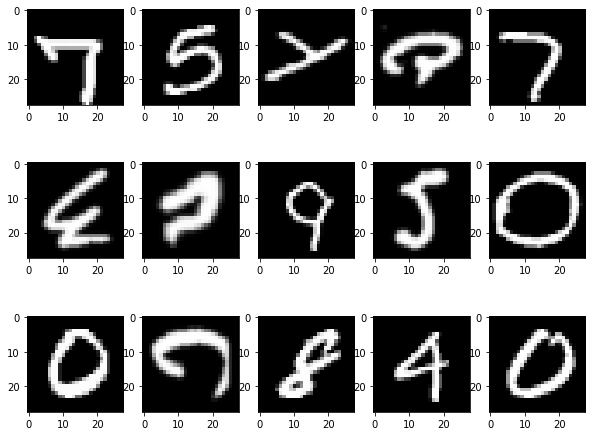

In [41]:
fig, axes = plt.subplots(3, 5, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28,28]), cmap=plt.get_cmap('gray'))

In [42]:
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)

num_classes = y_test_ohe.shape[1]
num_classes

36

## K-Nearest Neighbors

In [43]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train_ohe)

KNeighborsClassifier()

In [44]:
knn_predicted = knn.predict(X_test)

In [51]:
print('Accuracy: ', accuracy_score(y_test_ohe, knn_predicted))

Accuracy:  0.8668540241120887


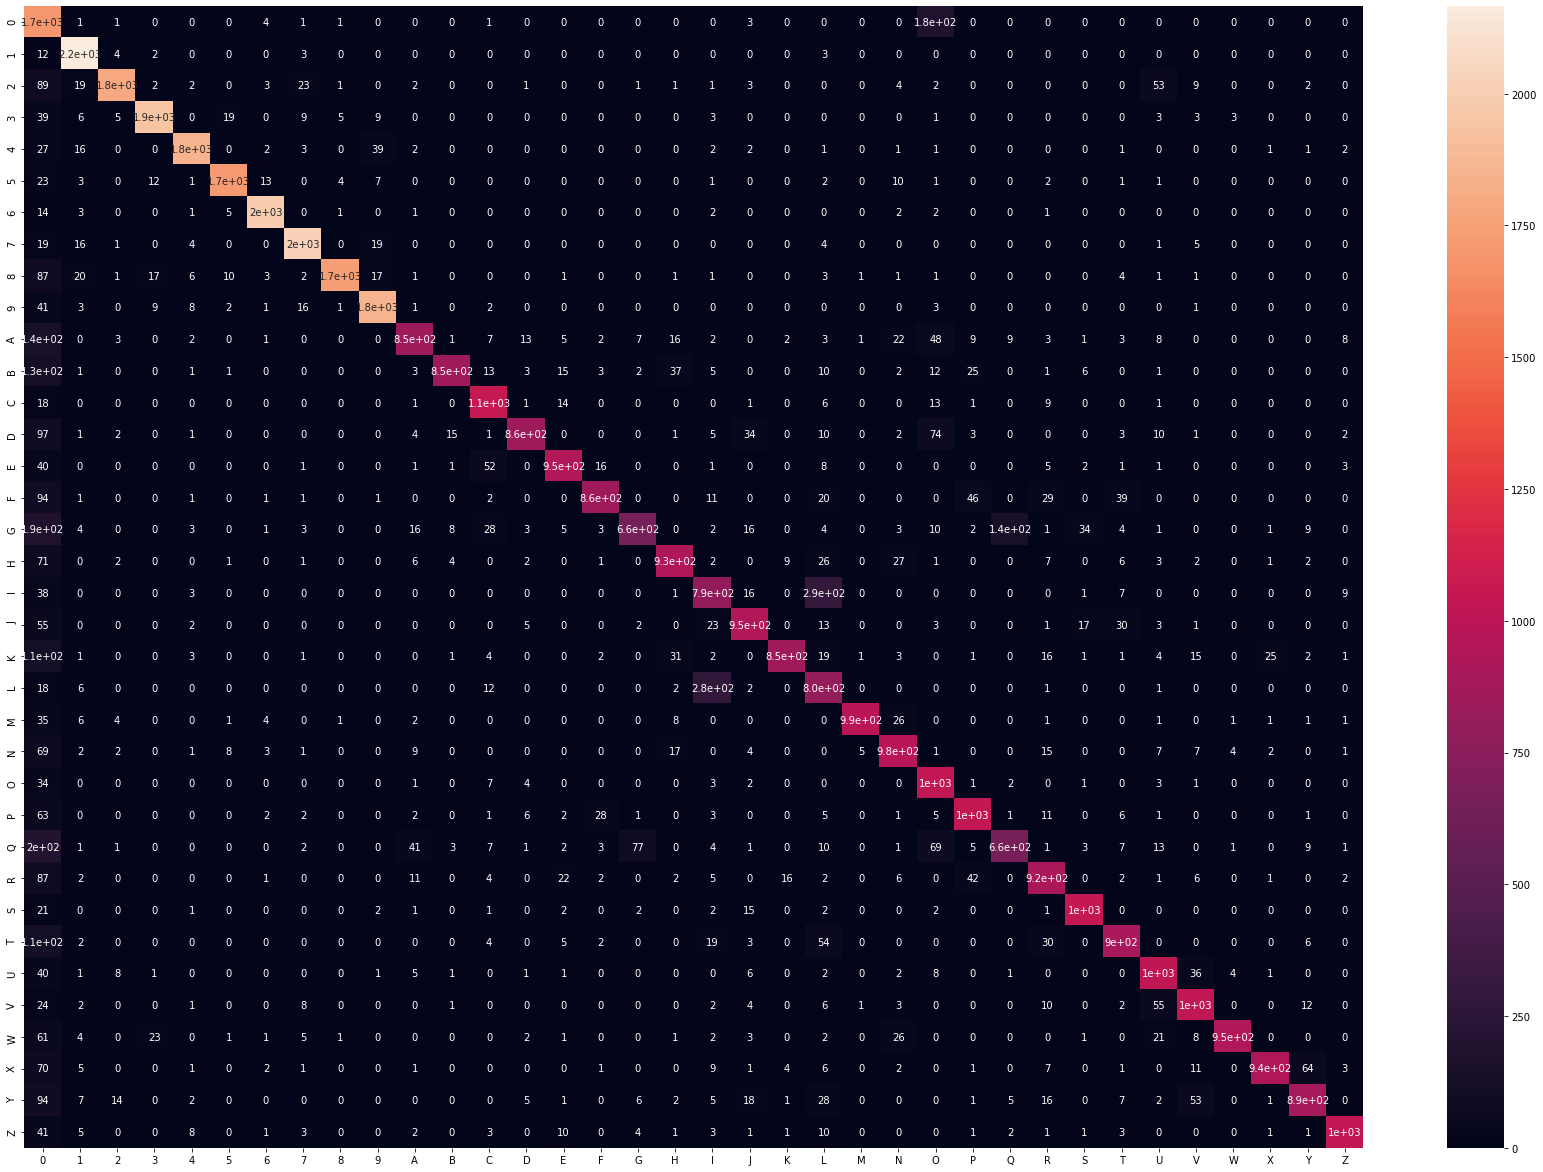

In [52]:
axis_labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

create_confusion(y_test_ohe, knn_predicted, axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.924097 (macro), 
0.932280 (weighted)

One-vs-Rest ROC AUC scores:
0.924097 (macro), 
0.932280 (weighted)


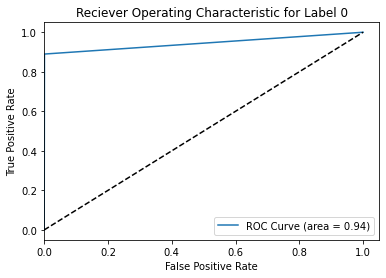

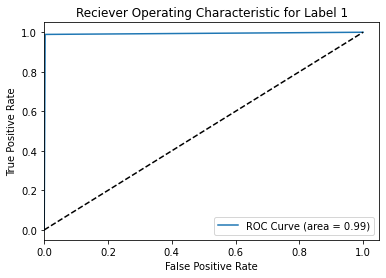

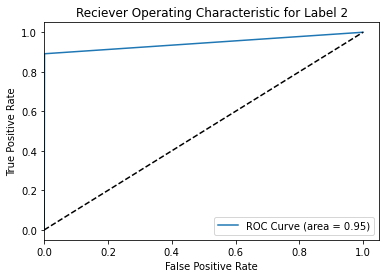

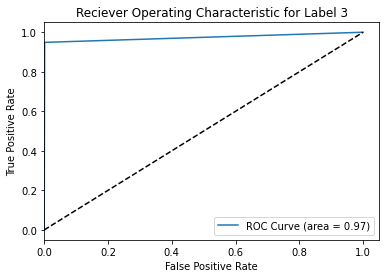

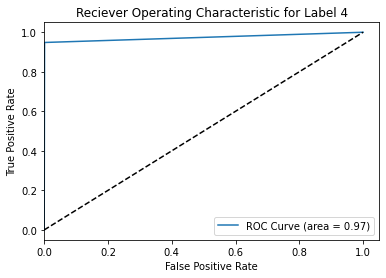

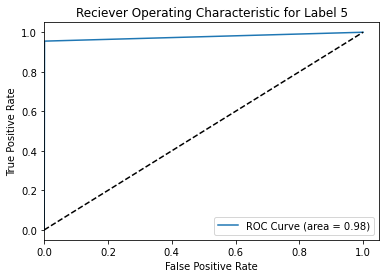

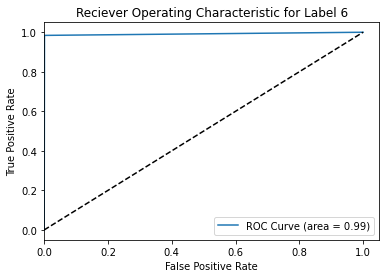

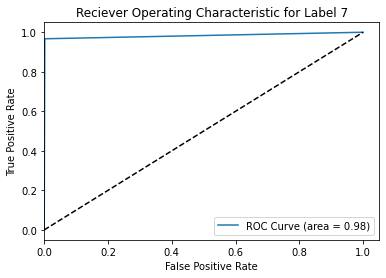

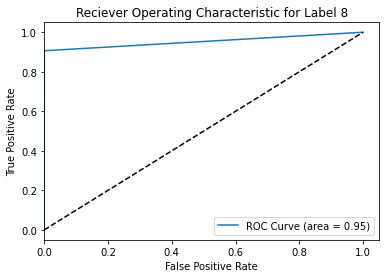

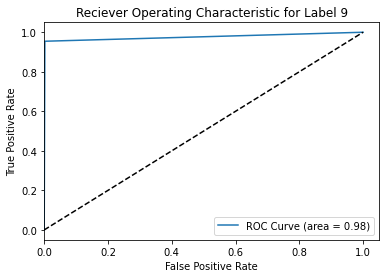

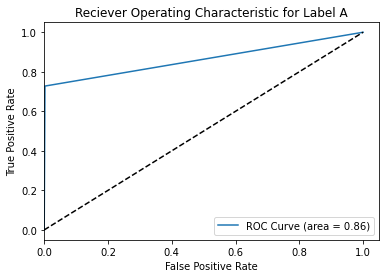

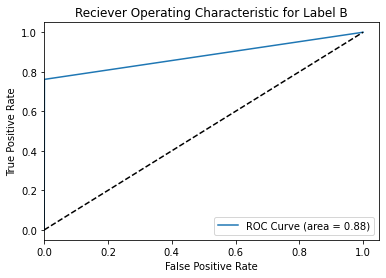

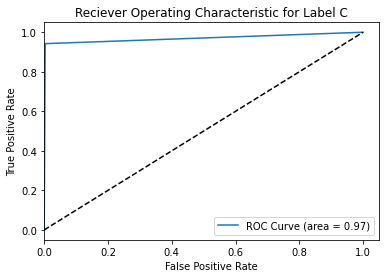

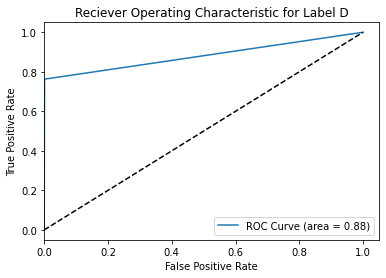

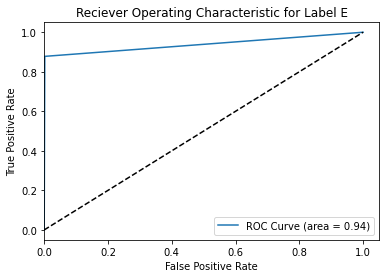

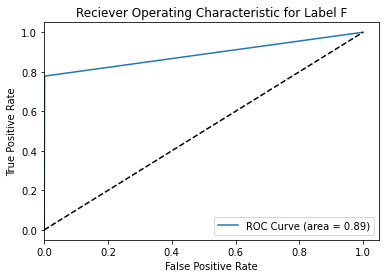

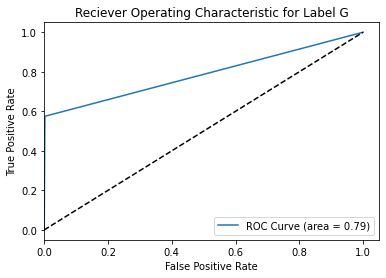

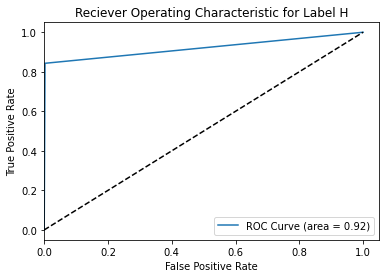

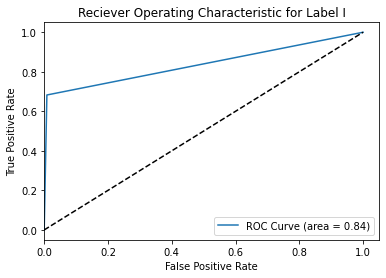

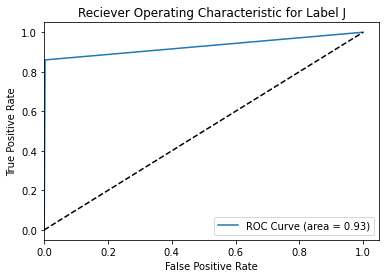

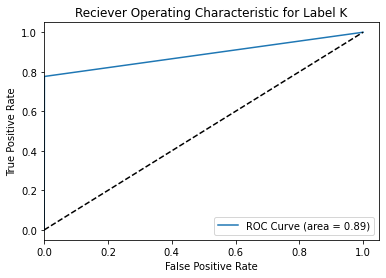

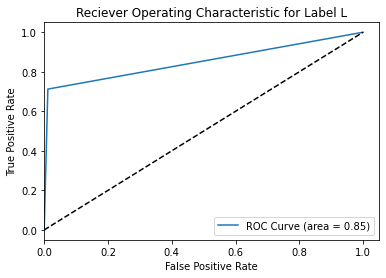

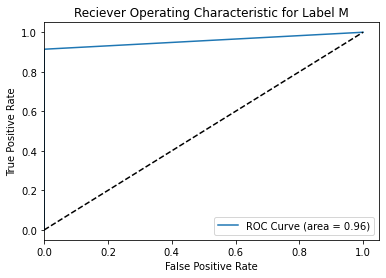

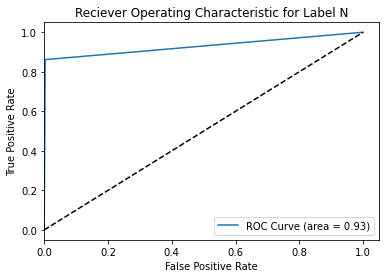

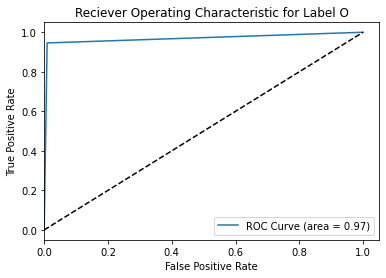

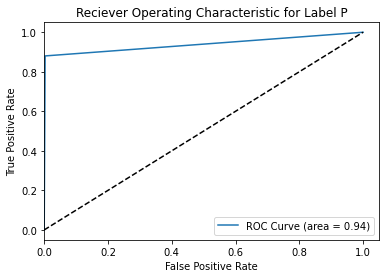

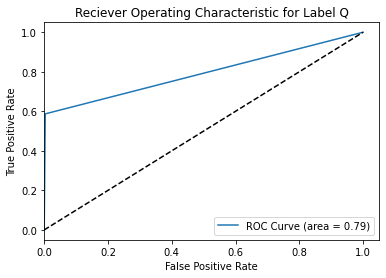

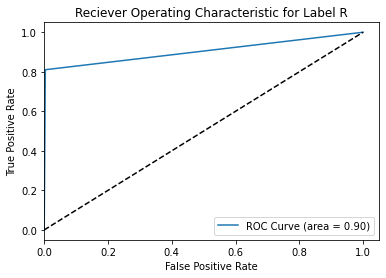

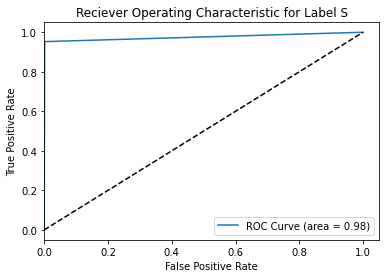

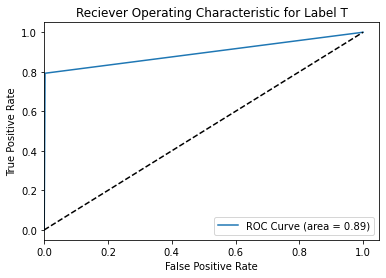

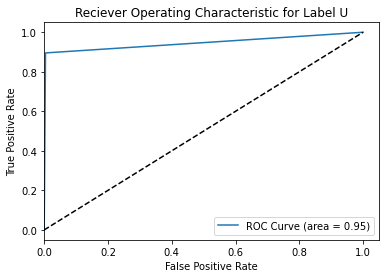

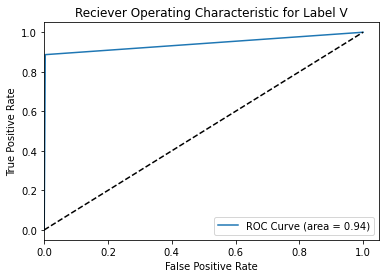

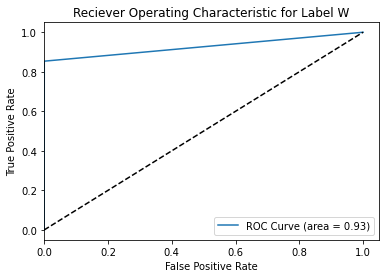

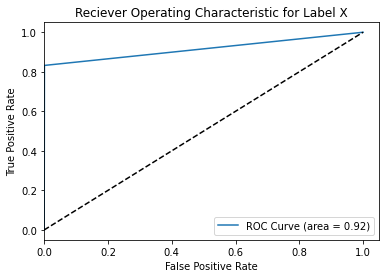

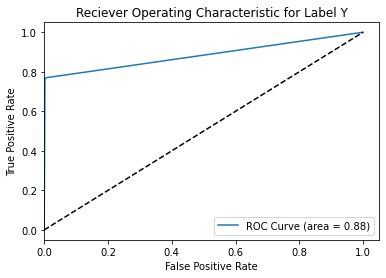

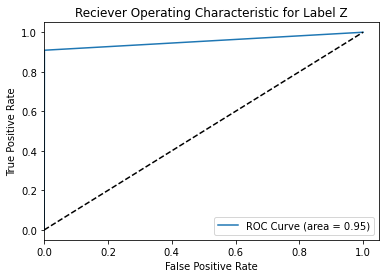

In [60]:
roc_auc(y_test_ohe, knn_predicted, num_classes)

## Logistic Regression

In [62]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [71]:
logreg_predicted = logreg.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, logreg_predicted))

Accuracy:  0.7769020853698273


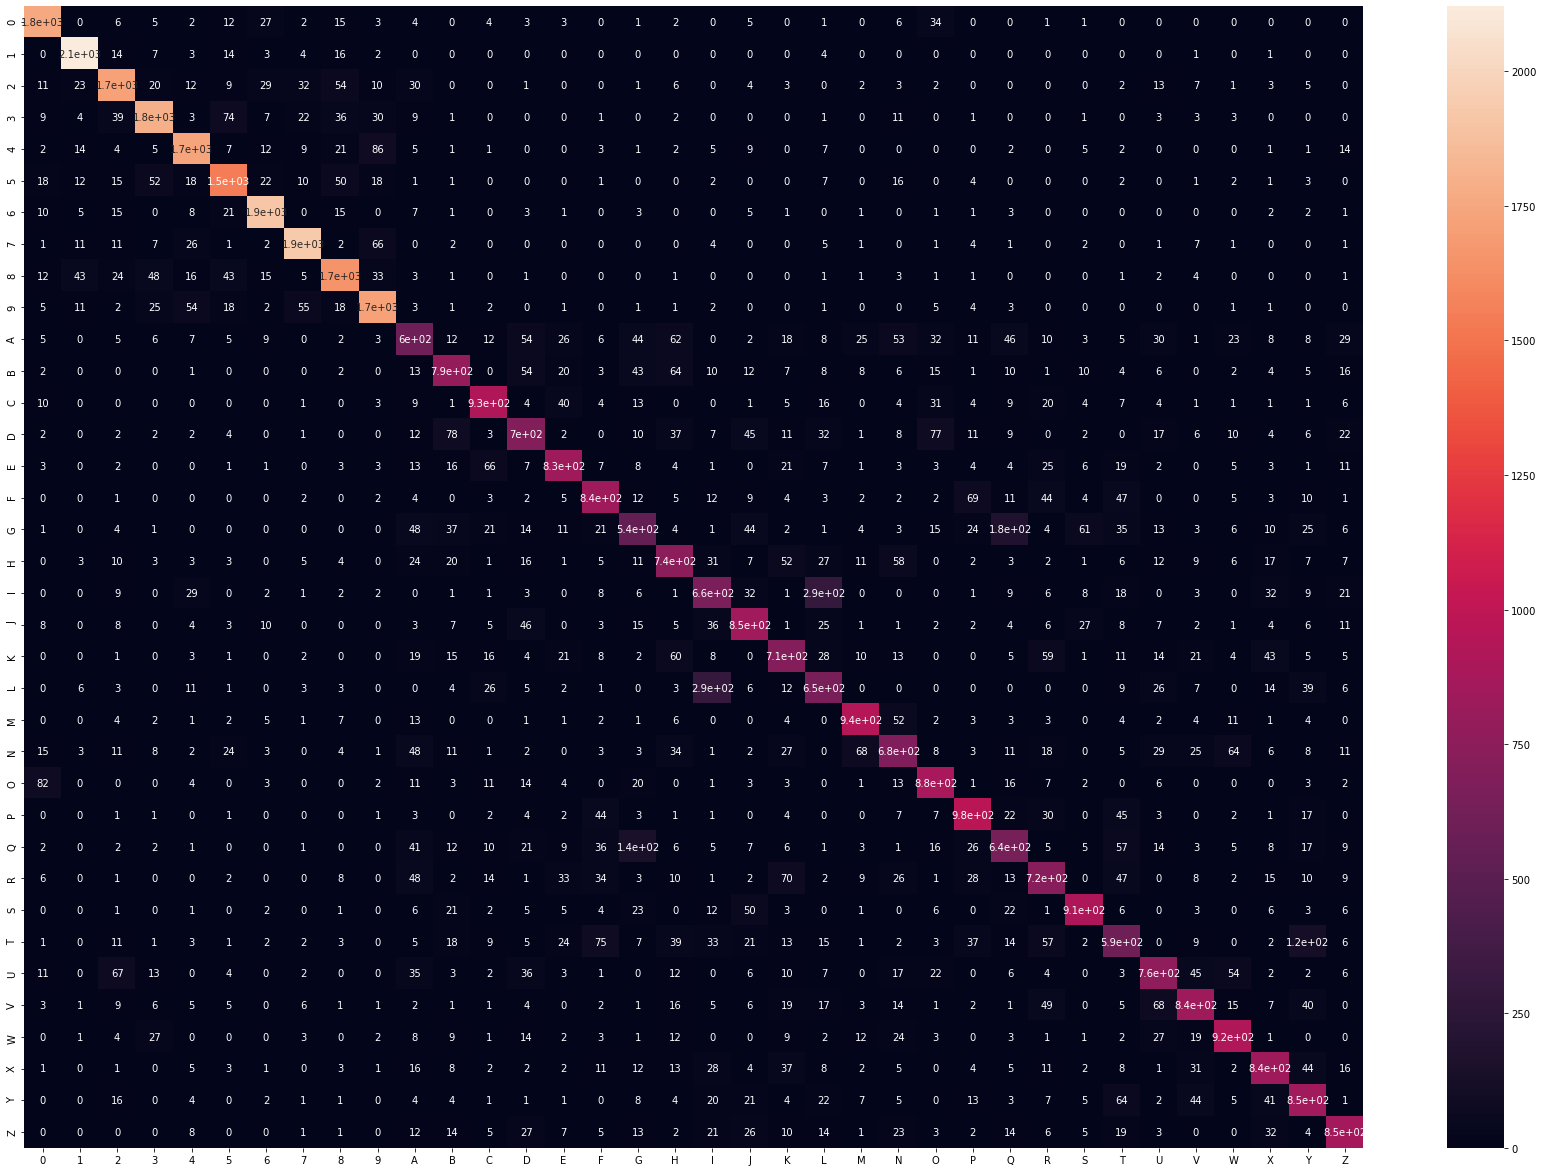

In [72]:
logreg_predicted_ohe = np_utils.to_categorical(logreg_predicted)

create_confusion(y_test_ohe, logreg_predicted_ohe, axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.872283 (macro), 
0.885406 (weighted)

One-vs-Rest ROC AUC scores:
0.872283 (macro), 
0.885406 (weighted)


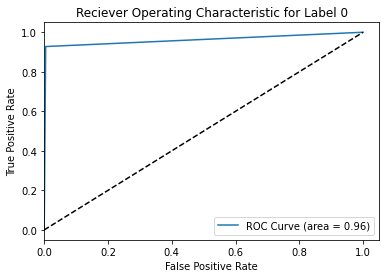

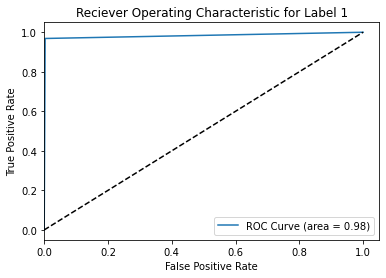

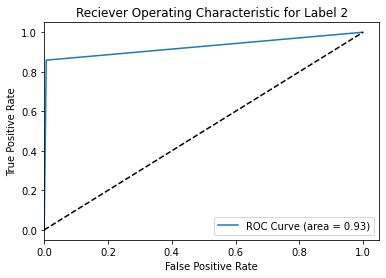

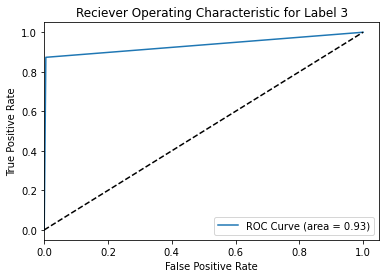

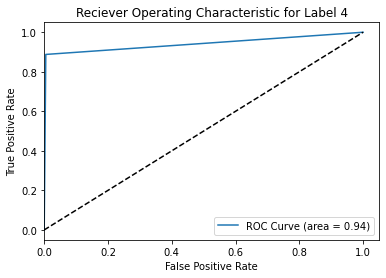

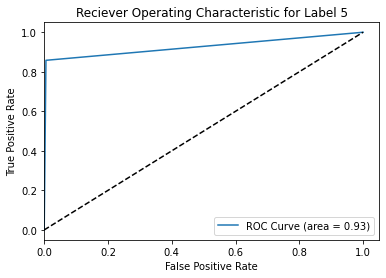

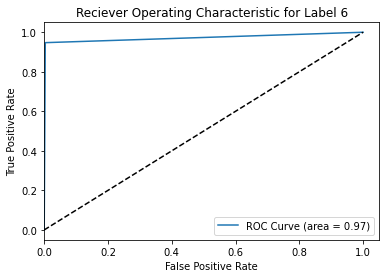

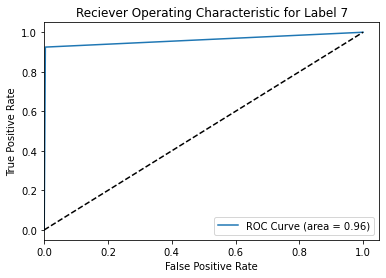

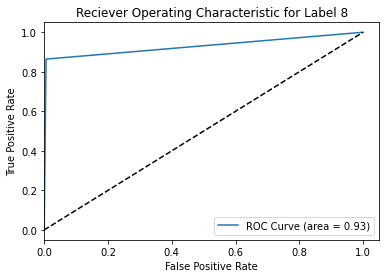

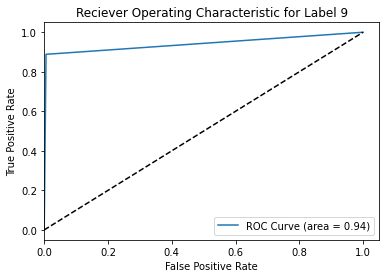

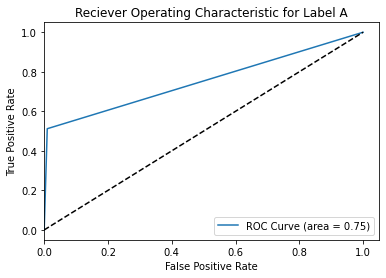

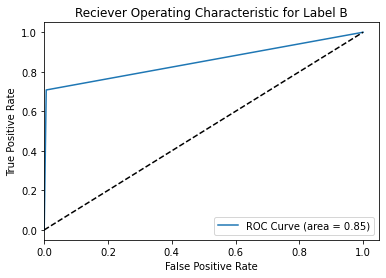

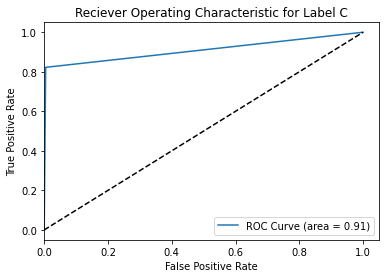

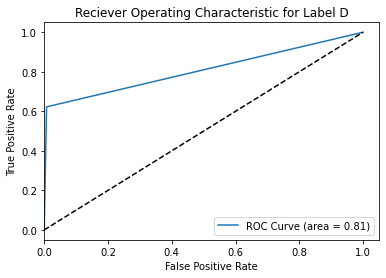

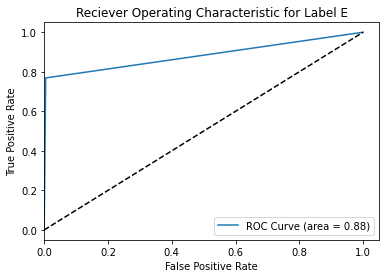

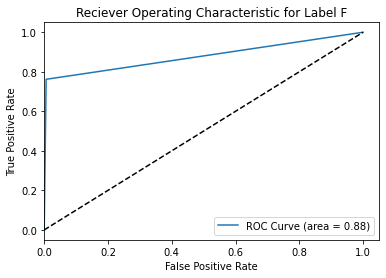

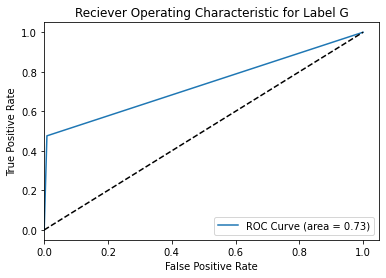

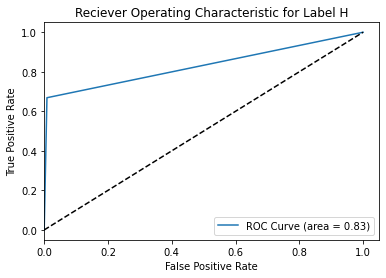

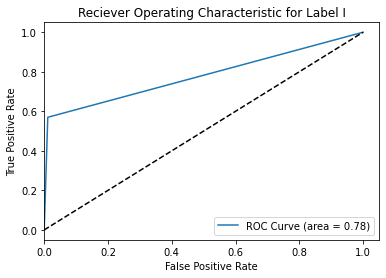

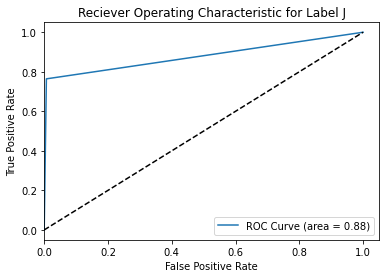

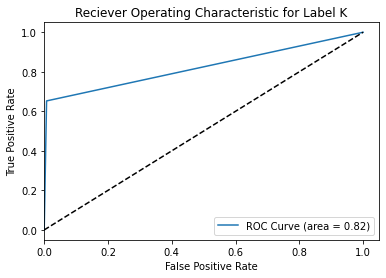

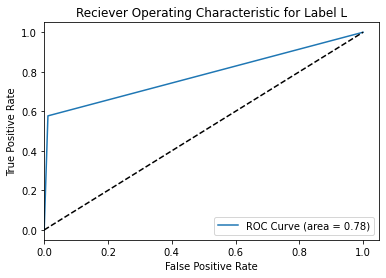

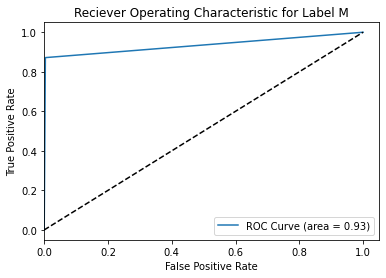

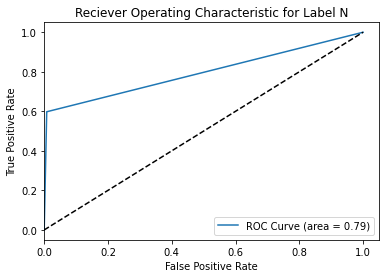

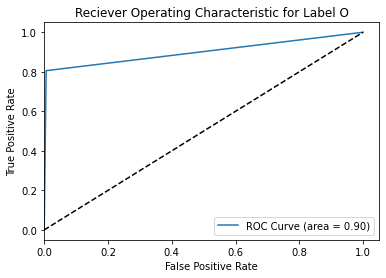

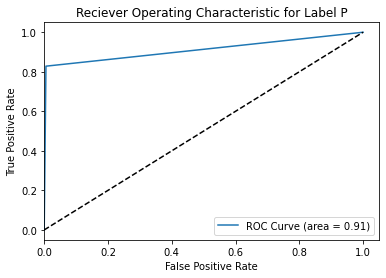

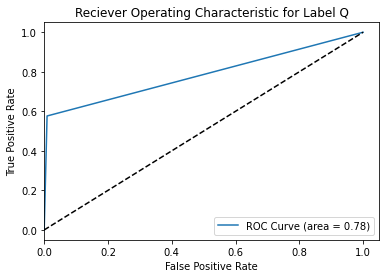

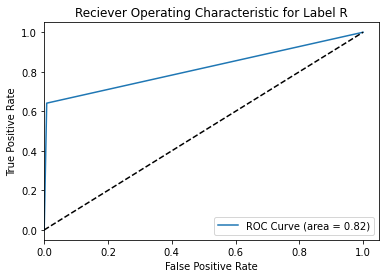

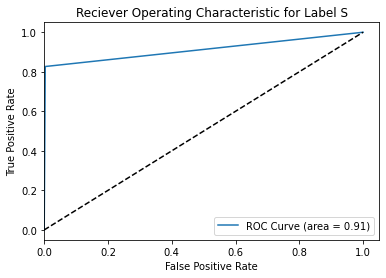

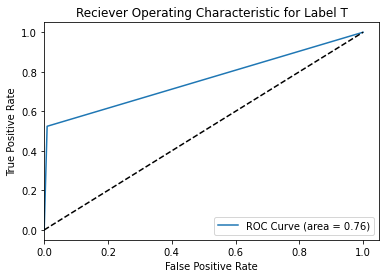

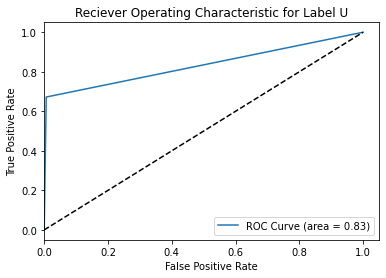

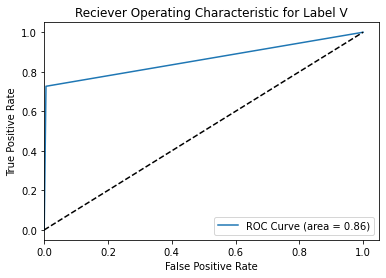

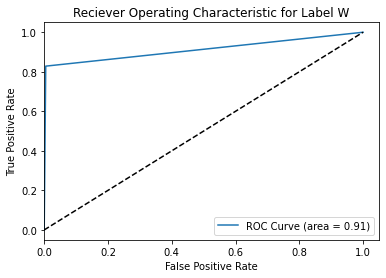

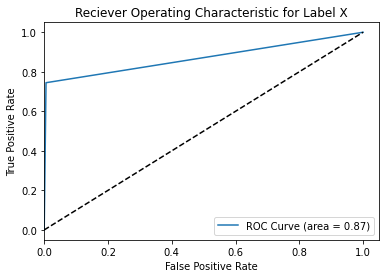

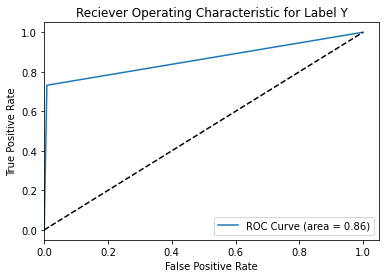

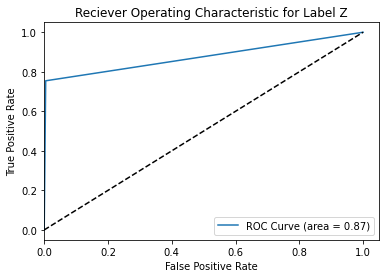

In [73]:
roc_auc(y_test_ohe, logreg_predicted_ohe, num_classes)

## Simple Neural Network

In [74]:
model = simple_nn(num_classes)
model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=200, verbose=2)

accuracy = model.evaluate(X_test, y_test_ohe, verbose=0)
print('Accuracy: ', accuracy[1])

Train on 99695 samples, validate on 49104 samples
Epoch 1/10
 - 7s - loss: 0.7547 - accuracy: 0.7909 - val_loss: 0.4588 - val_accuracy: 0.8621
Epoch 2/10
 - 7s - loss: 0.3615 - accuracy: 0.8937 - val_loss: 0.3416 - val_accuracy: 0.8960
Epoch 3/10
 - 7s - loss: 0.2655 - accuracy: 0.9188 - val_loss: 0.3004 - val_accuracy: 0.9088
Epoch 4/10
 - 7s - loss: 0.2158 - accuracy: 0.9333 - val_loss: 0.2662 - val_accuracy: 0.9171
Epoch 5/10
 - 7s - loss: 0.1797 - accuracy: 0.9436 - val_loss: 0.2598 - val_accuracy: 0.9177
Epoch 6/10
 - 7s - loss: 0.1540 - accuracy: 0.9502 - val_loss: 0.2474 - val_accuracy: 0.9228
Epoch 7/10
 - 7s - loss: 0.1329 - accuracy: 0.9565 - val_loss: 0.2397 - val_accuracy: 0.9256
Epoch 8/10
 - 7s - loss: 0.1143 - accuracy: 0.9616 - val_loss: 0.2453 - val_accuracy: 0.9254
Epoch 9/10
 - 7s - loss: 0.1004 - accuracy: 0.9665 - val_loss: 0.2532 - val_accuracy: 0.9227
Epoch 10/10
 - 7s - loss: 0.0894 - accuracy: 0.9697 - val_loss: 0.2517 - val_accuracy: 0.9267
Accuracy:  0.926686

In [77]:
nn_predicted = model.predict(X_test, batch_size=200, verbose=2)
print('Accuracy: ', accuracy_score(y_test, np.argmax(nn_predicted, axis=1)))

Accuracy:  0.9266862170087976


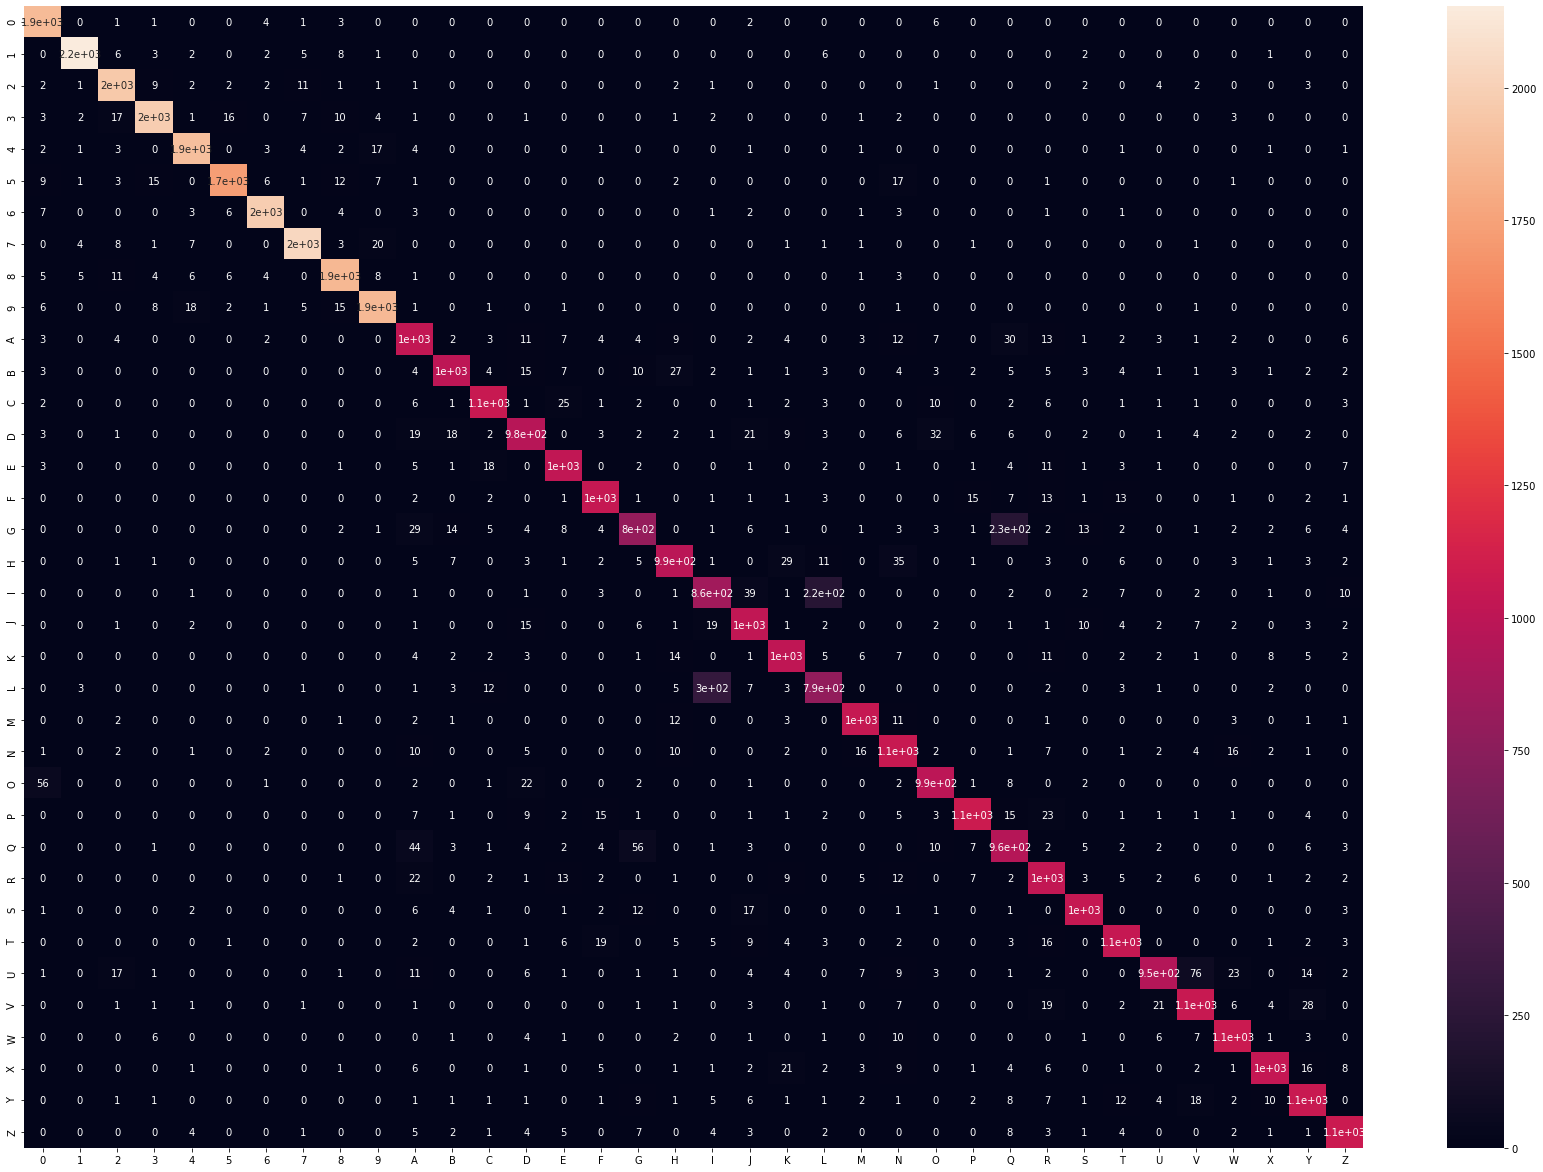

In [78]:
create_confusion(y_test_ohe, nn_predicted, axis_labels)

C:\Users\Patrick\anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


One-vs-One ROC AUC scores:
0.998263 (macro), 
0.998510 (weighted)

One-vs-Rest ROC AUC scores:
0.998263 (macro), 
0.998510 (weighted)


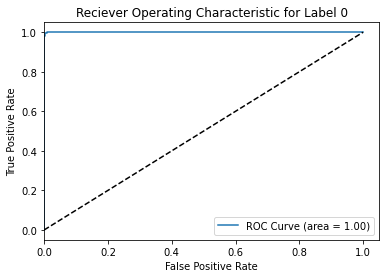

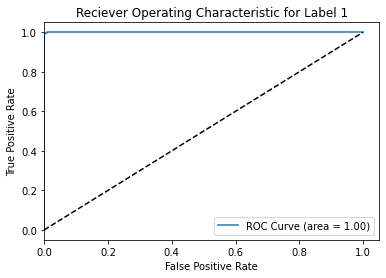

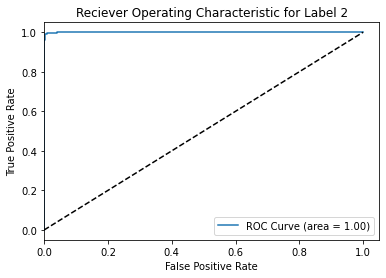

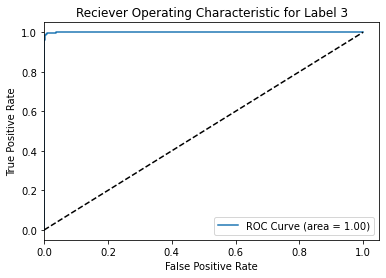

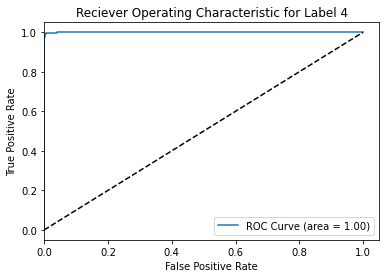

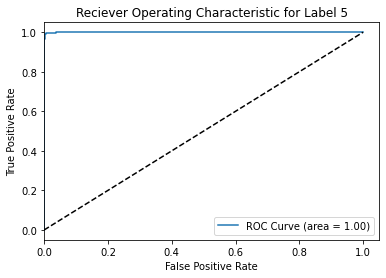

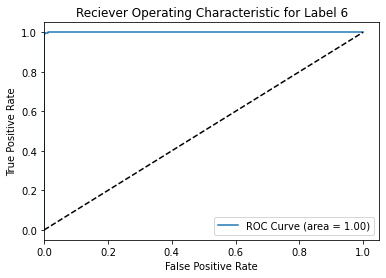

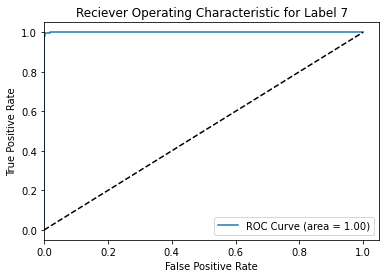

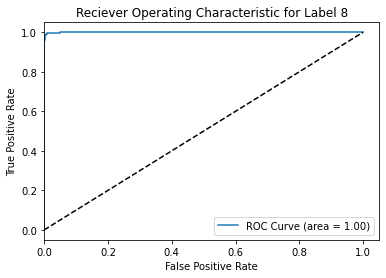

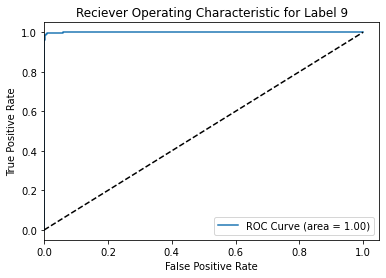

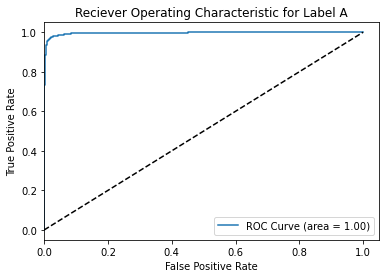

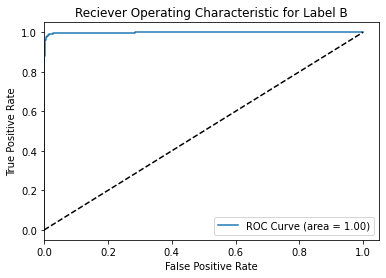

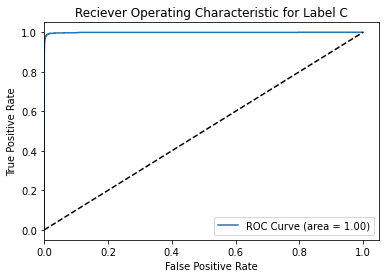

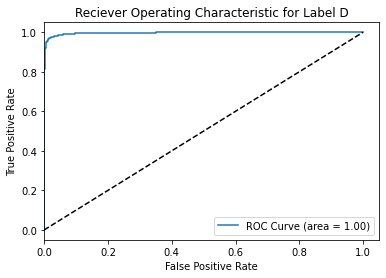

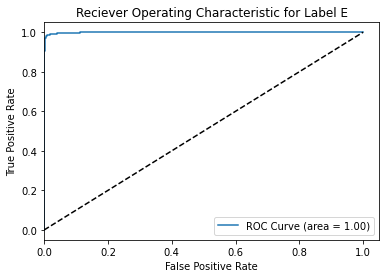

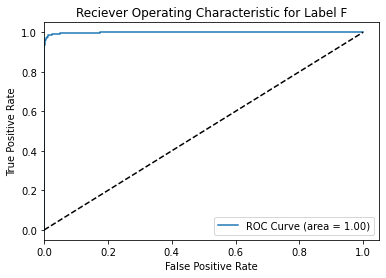

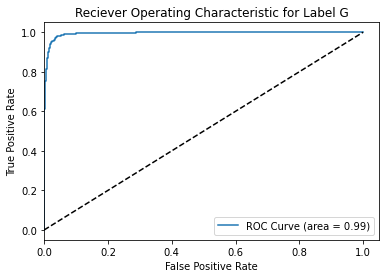

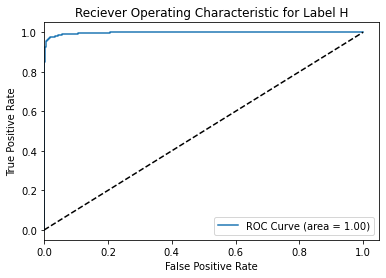

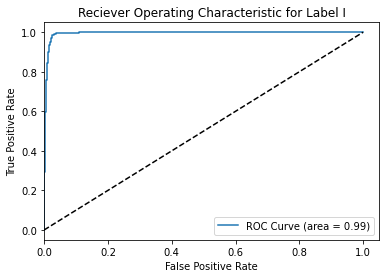

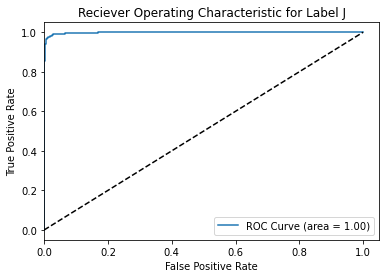

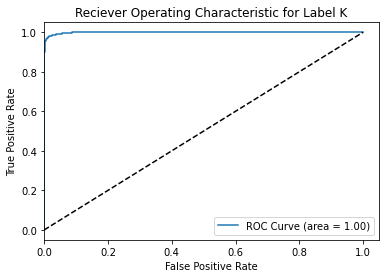

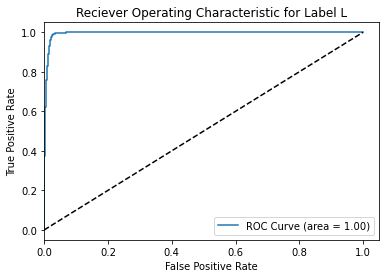

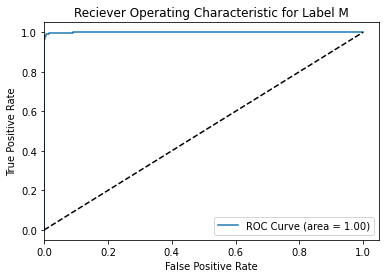

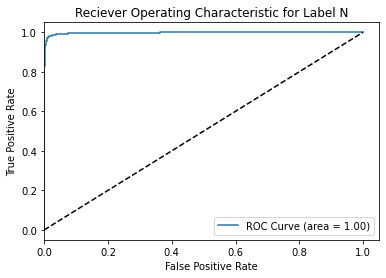

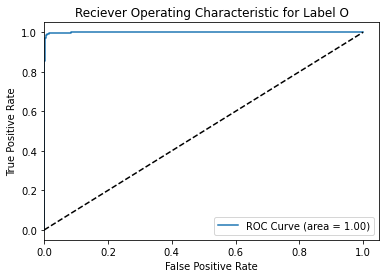

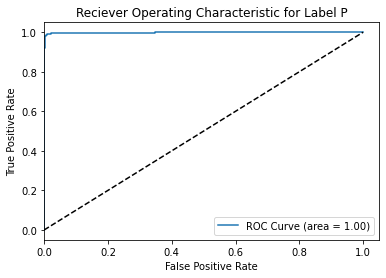

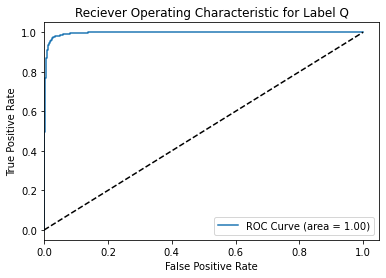

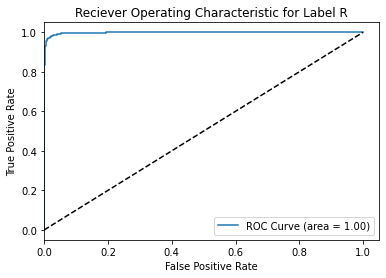

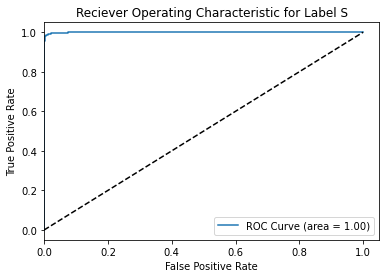

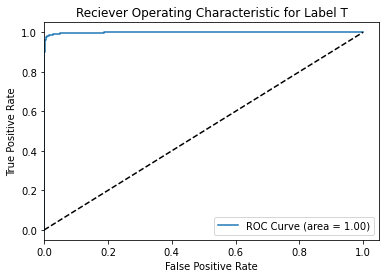

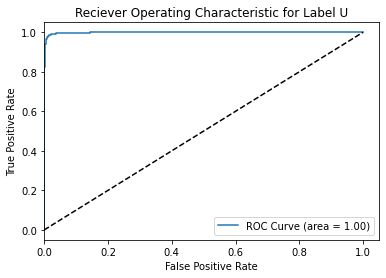

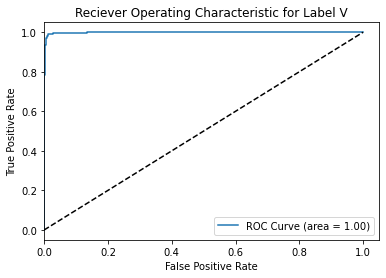

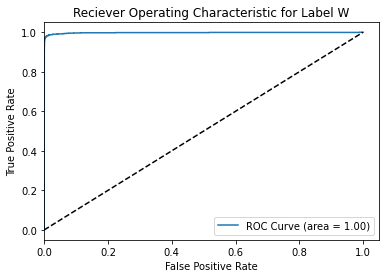

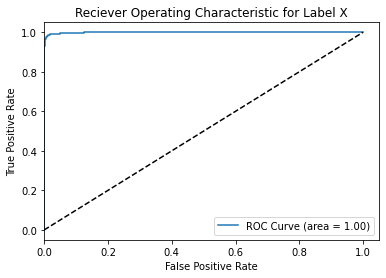

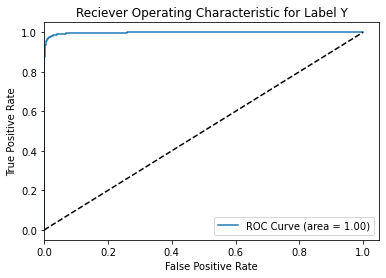

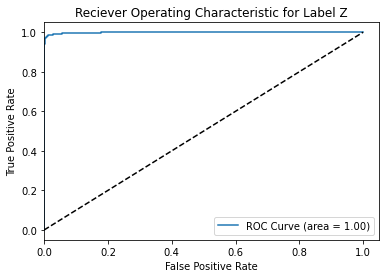

In [79]:
roc_auc(y_test_ohe, nn_predicted, num_classes)

# Image Processing

<function matplotlib.pyplot.show(close=None, block=None)>

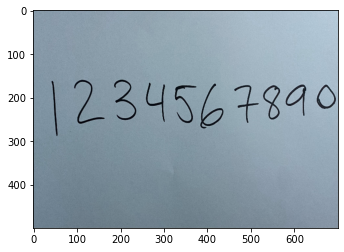

In [81]:
image = cv2.imread('number_test4.jpg')
image = cv2.resize(image, (700, 500))
plt.imshow(image, cmap='gray')
plt.show

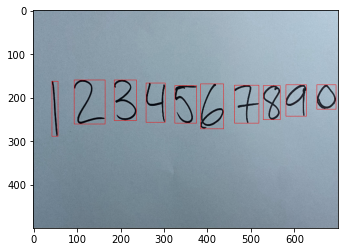

In [85]:
data, df = process_image('number_test4.jpg')

In [89]:
nn_predicted = model.predict(data, batch_size=200, verbose=2)
np.argmax(nn_predicted, axis=1)

array([1, 2, 3, 4, 5, 2, 3, 8, 9, 0], dtype=int64)

<function matplotlib.pyplot.show(close=None, block=None)>

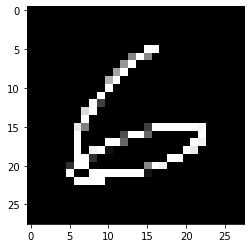

In [104]:
digits = data.reshape(10, 28, 28)
plt.imshow(digits[5], cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

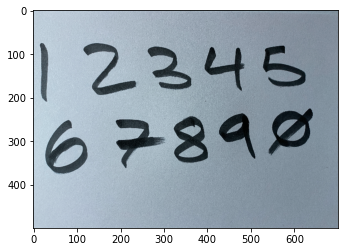

In [105]:
image = cv2.imread('number_test_rows.jpg')
image = cv2.resize(image, (700, 500))
plt.imshow(image, cmap='gray')
plt.show

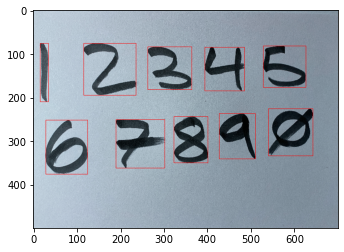

In [106]:
data, df = process_image('number_test_rows.jpg')

In [107]:
nn_predicted = model.predict(data, batch_size=200, verbose=2)
np.argmax(nn_predicted, axis=1)

array([23,  2,  2,  4,  5,  6, 27,  8, 10, 23], dtype=int64)

<function matplotlib.pyplot.show(close=None, block=None)>

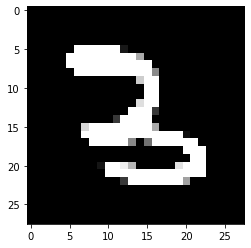

In [109]:
digits = data.reshape(10, 28, 28)
plt.imshow(digits[2], cmap='gray')
plt.show